Импорт библиотек

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import cv2
import mediapipe as mp
import warnings
warnings.filterwarnings('ignore')

# ML библиотеки
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix
)
import joblib
import json
import os
from pathlib import Path
import time
import albumentations as A

print("Библиотеки загружены")

Библиотеки загружены


Конфигурация

In [20]:
class Config:
    # Пути
    DATASET_PATH = "Drowsiness_dataset/"
    OUTPUT_PATH = "scientific_results/"
    
    # Пути к поддиректориям
    TRAIN_PATH = "train/"
    VAL_PATH = "val/"
    TEST_PATH = "test/"
    
    # ИНДЕКСЫ ДЛЯ ФОРМУЛЫ MAR (4 точки)
    MAR_TOP_INDEX = 13       # Центр верхней губы
    MAR_BOTTOM_INDEX = 14    # Центр нижней губы
    MAR_LEFT_INDEX = 78      # Левый угол рта
    MAR_RIGHT_INDEX = 308    # Правый угол рта
    
    NOSE_TIP_INDEX = 1  # Кончик носа
    CHIN_INDEX = 152  # Подбородок
    
    # Параметры аугментации
    AUGMENTATION_FACTOR = 5
    MAX_SAMPLES_PER_CLASS = 2000
    
    # Добавляем параметры для балансировки
    BALANCE_CLASSES = True
    MIN_SAMPLES_PER_CLASS = 500

    # Пороги для статистики
    STAT_SIGNIFICANCE = 0.05
    
    def __init__(self):
        os.makedirs(self.OUTPUT_PATH, exist_ok=True)
        os.makedirs(os.path.join(self.OUTPUT_PATH, "plots"), exist_ok=True)
        os.makedirs(os.path.join(self.OUTPUT_PATH, "models"), exist_ok=True)

config = Config()
print("Конфигурация загружена")
print(f"Путь к датасету: {config.DATASET_PATH}")
print(f"Путь для результатов: {config.OUTPUT_PATH}")

Конфигурация загружена
Путь к датасету: Drowsiness_dataset/
Путь для результатов: scientific_results/


Загрузка датасета и аугментация

In [21]:
class AugmentedDatasetLoader:
    def __init__(self, config):
        self.config = config
        self.yawn_images = {}
        self.no_yawn_images = {}
        
    def load_dataset_structure(self):
        """Загрузка структуры датасета"""
        print("Проверка структуры датасета...")
        
        dataset_dir = Path(self.config.DATASET_PATH)
        
        if not dataset_dir.exists():
            print(f"Папка датасета не найдена: {self.config.DATASET_PATH}")
            return False
        
        yawn_dir = dataset_dir / "yawn"
        no_yawn_dir = dataset_dir / "no_yawn"
        
        if not yawn_dir.exists() or not no_yawn_dir.exists():
            print("Неверная структура датасета.")
            return False
        
        # Собираем пути
        self.yawn_images = {
            'train': list(yawn_dir.glob("train/*.jpg")) + list(yawn_dir.glob("train/*.png")),
            'val': list(yawn_dir.glob("val/*.jpg")) + list(yawn_dir.glob("val/*.png")),
            'test': list(yawn_dir.glob("test/*.jpg")) + list(yawn_dir.glob("test/*.png"))
        }
        
        self.no_yawn_images = {
            'train': list(no_yawn_dir.glob("train/*.jpg")) + list(no_yawn_dir.glob("train/*.png")),
            'val': list(no_yawn_dir.glob("val/*.jpg")) + list(no_yawn_dir.glob("val/*.png")),
            'test': list(no_yawn_dir.glob("test/*.jpg")) + list(no_yawn_dir.glob("test/*.png"))
        }
        
        print("Структура проверена:")
        for split in ['train', 'val', 'test']:
            yawn_count = len(self.yawn_images[split])
            no_yawn_count = len(self.no_yawn_images[split])
            print(f"{split.upper()}: Зевок={yawn_count}, Без зевка={no_yawn_count}")
        
        return True
    
    def apply_augmentation(self, image):
        """Аугментация изображения"""
        try:
            transform = A.Compose([
                # Изменение яркости и контраста
                A.RandomBrightnessContrast(
                    brightness_limit=0.2,
                    contrast_limit=0.2,
                    brightness_by_max=True,
                    p=0.8
                ),
                
                # Случайные повороты
                A.Rotate(
                    limit=15,
                    border_mode=cv2.BORDER_CONSTANT,
                    value=0,
                    mask_value=0,
                    p=0.7
                ),
                
                # Горизонтальное отражение
                A.HorizontalFlip(p=0.5),
                
                # Лёгкое размытие в движении
                A.MotionBlur(
                    blur_limit=(3, 7),
                    allow_shifted=True,
                    p=0.4
                ),
                
                # Добавление гауссова шума
                A.GaussNoise(
                    var_limit=(0.0001, 0.01),
                    mean=0,
                    per_channel=True,
                    p=0.3
                )
            ])
                        
            return transform(image=image)['image']
            
        except Exception as e:
            # Упрощенная аугментация
            result = image.copy()
            alpha = 1.0 + np.random.uniform(-0.2, 0.2)
            beta = np.random.uniform(-30, 30)
            result = cv2.convertScaleAbs(result, alpha=alpha, beta=beta)
            
            if np.random.random() > 0.5:
                result = cv2.flip(result, 1)
            
            return result
    
    def visualize_augmentation(self, image_path, n_examples=3):
        """Визуализация эффекта аугментации"""
        img = cv2.imread(str(image_path))
        if img is None:
            print(f"Не удалось загрузить: {image_path}")
            return
        
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig, axes = plt.subplots(1, n_examples + 1, figsize=(12, 3))
        
        axes[0].imshow(img_rgb)
        axes[0].set_title('Оригинал')
        axes[0].axis('off')
        
        for i in range(n_examples):
            augmented = self.apply_augmentation(img_rgb)
            axes[i + 1].imshow(augmented)
            axes[i + 1].set_title(f'Аугм. {i+1}')
            axes[i + 1].axis('off')
        
        plt.suptitle('Примеры аугментации (только для train)')
        plt.tight_layout()
        
        output_path = f"{self.config.OUTPUT_PATH}/plots/augmentation_examples.png"
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        print(f"График сохранен: {output_path}")
        plt.show()

print("AugmentedDatasetLoader создан")

AugmentedDatasetLoader создан


Извлечение признаков (с аугментацией и без)

In [22]:
class FeatureExtractor:
    def __init__(self, config):
        self.config = config
        self.mp_face_mesh = mp.solutions.face_mesh
        self.loader = AugmentedDatasetLoader(config)
        
    def extract_features_batch(self, image_paths, labels, split='train'):
        """Извлечение признаков MAR и расстояния нос-подбородок из оригинальных изображений"""
        
        print(f"Извлечение признаков для {split.upper()}...")
        
        features_list = []
        face_mesh = self.mp_face_mesh.FaceMesh(
            static_image_mode=True,
            max_num_faces=1,
            refine_landmarks=True,
            min_detection_confidence=0.3
        )
        
        processed = 0
        skipped = 0
        
        for i, img_path in enumerate(image_paths):
            if i % 50 == 0 and i > 0:
                print(f"  Обработано {i}/{len(image_paths)}...")
            
            features = self._extract_single_image(str(img_path), face_mesh, labels[i], split)
            
            if features:
                features_list.append(features)
                processed += 1
            else:
                skipped += 1
        
        face_mesh.close()
        
        print(f"Результаты для {split.upper()}:")
        print(f"  Успешно: {processed} изображений")
        print(f"  Пропущено: {skipped} изображений")
        
        return features_list
    
    def extract_features_with_augmentation(self, image_paths, labels, augmentation_factor=5):
        """Извлечение признаков с аугментацией изображений для ML"""
        print(f"Извлечение признаков с аугментацией (factor={augmentation_factor})...")
        
        features_list = []
        face_mesh = self.mp_face_mesh.FaceMesh(
            static_image_mode=True,
            max_num_faces=1,
            refine_landmarks=True,
            min_detection_confidence=0.3
        )
        
        processed = 0
        augmented_count = 0
        
        for i, img_path in enumerate(image_paths):
            # Оригинальное изображение
            img = cv2.imread(str(img_path))
            if img is None:
                continue
            
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            results = face_mesh.process(img_rgb)
            
            if results.multi_face_landmarks:
                features = self._extract_from_image(img_rgb, results, str(img_path), labels[i], 'train')
                if features:
                    features_list.append(features)
                    processed += 1
                
                # Аугментированные версии
                for aug_idx in range(augmentation_factor - 1):
                    augmented_img = self.loader.apply_augmentation(img_rgb)
                    
                    # Повторная обработка аугментированного изображения
                    results_aug = face_mesh.process(augmented_img)
                    if results_aug.multi_face_landmarks:
                        features_aug = self._extract_from_image(
                            augmented_img, results_aug, 
                            f"{Path(img_path).stem}_aug{aug_idx}", 
                            labels[i], 'train'
                        )
                        if features_aug:
                            features_list.append(features_aug)
                            augmented_count += 1
            
            if i % 20 == 0 and i > 0:
                print(f"  Обработано {i}/{len(image_paths)}, {len(features_list)} образцов...")
        
        face_mesh.close()
        
        print(f"Аугментация завершена:")
        print(f"  Оригинальных: {processed} изображений")
        print(f"  Аугментированных: {augmented_count} изображений")
        print(f"  Всего: {len(features_list)} образцов")
        
        return features_list
    
    def _extract_from_image(self, img_rgb, results, image_name, label, split):
        """Извлечение признаков из конкретного изображения"""
        try:
            if not results.multi_face_landmarks:
                return None
            
            landmarks = results.multi_face_landmarks[0]
            h, w = img_rgb.shape[:2]
            
            mar = self._calculate_mar(landmarks, h, w)
            nose_chin_distance = self._calculate_nose_chin_distance(landmarks, h, w)
            
            return {
                'image_path': image_name,
                'mar': mar,
                'nose_chin_distance': nose_chin_distance,
                'label': label,
                'split': split
            }
        except Exception as e:
            return None
    
    def _extract_single_image(self, img_path, face_mesh, label, split):
        """Обработка одного изображения и извлечение признаков"""
        try:
            img = cv2.imread(img_path)
            if img is None:
                return None
            
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            results = face_mesh.process(img_rgb)
            
            if not results.multi_face_landmarks:
                return None
            
            return self._extract_from_image(img_rgb, results, Path(img_path).stem, label, split)
            
        except Exception as e:
            return None
    
    def _calculate_mar(self, landmarks, h, w):
        """Расчет Mouth Aspect Ratio (MAR) по 4 ключевым точкам"""
        top = landmarks.landmark[self.config.MAR_TOP_INDEX]
        bottom = landmarks.landmark[self.config.MAR_BOTTOM_INDEX]
        left = landmarks.landmark[self.config.MAR_LEFT_INDEX]
        right = landmarks.landmark[self.config.MAR_RIGHT_INDEX]
        
        top_point = (top.x * w, top.y * h)
        bottom_point = (bottom.x * w, bottom.y * h)
        left_point = (left.x * w, left.y * h)
        right_point = (right.x * w, right.y * h)
        
        vertical = np.sqrt((top_point[0] - bottom_point[0])**2 + (top_point[1] - bottom_point[1])**2)
        horizontal = np.sqrt((left_point[0] - right_point[0])**2 + (left_point[1] - right_point[1])**2)
        
        if horizontal > 0:
            mar = vertical / horizontal
        else:
            mar = 0.03
        
        if mar < 0.03:
            mar = 0.03
        
        return mar
    
    def _calculate_nose_chin_distance(self, landmarks, h, w):
        """Расчет нормализованного расстояния между носом и подбородком"""
        nose = landmarks.landmark[self.config.NOSE_TIP_INDEX]
        chin = landmarks.landmark[self.config.CHIN_INDEX]
        
        nose_point = np.array([nose.x * w, nose.y * h])
        chin_point = np.array([chin.x * w, chin.y * h])
        absolute_distance = np.linalg.norm(nose_point - chin_point)
        
        left_eye = landmarks.landmark[33]
        right_eye = landmarks.landmark[263]
        face_width = abs(left_eye.x - right_eye.x) * w
        
        return absolute_distance / face_width if face_width > 0 else 0

print("FeatureExtractor создан (с поддержкой аугментации)")

FeatureExtractor создан (с поддержкой аугментации)


Анализ

In [23]:
class ScientificAnalyzer:
    def __init__(self, df_features, data_source_description="все данные"):
        if 'mar' in df_features.columns:
            original_count = len(df_features)
            
            # ЗАМЕНА минимальных значений
            df_features['mar'] = df_features['mar'].apply(lambda x: max(x, 0.03) if x > 0 else 0.03)
            
            # Фильтрация только нереалистично больших значений
            df_features = df_features[df_features['mar'] <= 1.2]
            
            filtered_count = len(df_features)
            
            if original_count != filtered_count:
                removed = original_count - filtered_count
                print(f"Фильтрация MAR: удалено {removed} значений > 1.2")
                print(f"Значения MAR < 0.03 заменены на 0.03")
          
        self.df = df_features
        self.coefficients = {}
        self.statistical_results = {}
        self.data_source = data_source_description
        
    def perform_statistical_analysis(self):
        """Выполнение статистического анализа признаков"""
        yawn_df = self.df[self.df['label'] == 1]
        no_yawn_df = self.df[self.df['label'] == 0]
        
        print(f"Размер выборки: {len(self.df)} образцов")
        print(f"Зевок: {len(yawn_df)} образцов")
        print(f"Нет зевка: {len(no_yawn_df)} образцов")
        
        for feature in ['mar', 'nose_chin_distance']:
            print(f"\n--- Анализ признака: {feature.upper()} ---")
            
            yawn_values = yawn_df[feature]
            no_yawn_values = no_yawn_df[feature]
            
            if len(yawn_values) == 0 or len(no_yawn_values) == 0:
                continue
            
            # Основные статистики
            print(f"Зевок: среднее={yawn_values.mean():.3f}, ст.откл.={yawn_values.std():.3f}")
            print(f"Нет зевка: среднее={no_yawn_values.mean():.3f}, ст.откл.={no_yawn_values.std():.3f}")
            
            # U-тест Манна-Уитни
            u_stat, p_value = stats.mannwhitneyu(yawn_values, no_yawn_values)
            print(f"U-тест: U={u_stat:.0f}, p={p_value:.6f}")
            
            # Размер эффекта (Cohen's d)
            n1, n2 = len(yawn_values), len(no_yawn_values)
            cohens_d = 1 - (2 * u_stat) / (n1 * n2)
            print(f"Размер эффекта Cohen's d: {cohens_d:.3f}")
            
            # Для JSON сохраняем bool как int
            is_significant = p_value < 0.05
            
            self.statistical_results[feature] = {
                'p_value': float(p_value),
                'is_significant': int(is_significant),
                'effect_size': float(cohens_d),
                'mean_yawn': float(yawn_values.mean()),
                'mean_no_yawn': float(no_yawn_values.mean()),
                'median_yawn': float(yawn_values.median()),
                'median_no_yawn': float(no_yawn_values.median()),
                'n_yawn': int(len(yawn_values)),
                'n_no_yawn': int(len(no_yawn_values))
            }
        
        return self.statistical_results
    
    def calculate_coefficients(self):
        """Расчет коэффициентов K для адаптивной системы"""
        print("\n--- Расчет коэффициентов K ---")
        
        coefficients = {}
        
        for feature in ['mar', 'nose_chin_distance']:
            if feature in self.statistical_results:
                yawn_values = self.df[self.df['label'] == 1][feature]
                no_yawn_values = self.df[self.df['label'] == 0][feature]
                
                if len(yawn_values) > 0 and len(no_yawn_values) > 0:
                    if feature == 'mar':
                        # Для MAR используем 25-й перцентиль зевка
                        yawn_value = yawn_values.quantile(0.25)  # 25-й перцентиль
                        feature_name = "MAR_зевок (25% перцентиль)"
                        no_yawn_median = max(no_yawn_values.median(), 0.03)
                        print(f"  Корректировка MAR: базовая медиана = {no_yawn_median:.3f}")
                    else:
                        # Для nose_chin_distance используем медиану зевка
                        yawn_value = yawn_values.median()  # медиана
                        feature_name = "Расстояние_зевок (медиана)"
                        no_yawn_median = max(no_yawn_values.median(), 0.8)
                        print(f"  Корректировка расстояния: базовая медиана = {no_yawn_median:.3f}")
                    
                    if no_yawn_median > 0:
                        K = yawn_value / no_yawn_median
                    else:
                        K = 1.0
                    
                    print(f"\n{feature.upper()}:")
                    print(f"  {feature_name}: {yawn_value:.3f}")
                    print(f"  {feature.split('_')[0]}_закрытый (медиана): {no_yawn_median:.3f}")
                    print(f"  Коэффициент K: {K:.2f}")
                    
                    coefficients[f'K_{feature}'] = {
                        'value': float(K),
                        'yawn_value': float(yawn_value),
                        'no_yawn_median': float(no_yawn_median),
                        'metric_used': '25_percentile' if feature == 'mar' else 'median',
                        'mvp_formula': f'Порог_водителя = {feature}_калибровки × {K:.2f}'
                    }
        
        self.coefficients = coefficients
        self._save_coefficients()
        
        return self.coefficients
    
    def _save_coefficients(self):
        """Сохранение коэффициентов в JSON файл"""
        output_path = f"{config.OUTPUT_PATH}/scientific_coefficients.json"
        
        if os.path.exists(output_path):
            os.remove(output_path)
        
        report = {
            'coefficients': self.coefficients,
            'statistical_results': self.statistical_results,
            'timestamp': pd.Timestamp.now().isoformat(),
            'description': 'Коэффициенты для системы мониторинга зевка'
        }
        
        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump(report, f, indent=2, ensure_ascii=False)
        
        print(f"\nКоэффициенты сохранены: {output_path}")
    
    def generate_report(self):
        """Генерация текстового отчета"""
        report_lines = []
        
        report_lines.append("="*60)
        report_lines.append("ОТЧЕТ")
        report_lines.append("="*60)
        
        # Статистические результаты
        report_lines.append("\n1. СТАТИСТИЧЕСКИЙ АНАЛИЗ:")
        report_lines.append("-"*40)
        
        for feature, stats in self.statistical_results.items():
            significance = "значимо" if stats['is_significant'] else "не значимо"
            report_lines.append(f"{feature.upper()}: {significance} (p={stats['p_value']:.6f}, d={stats['effect_size']:.3f})")
        
        # Коэффициенты
        report_lines.append("\n2. РАСЧЕТ КОЭФФИЦИЕНТОВ K:")
        report_lines.append("-"*40)
        
        for coef_name, coef_data in self.coefficients.items():
            report_lines.append(f"{coef_name}: K = {coef_data['value']:.2f}")
            report_lines.append(f"  Формула: Порог = {coef_name.split('_')[1]}_калибровки × {coef_data['value']:.2f}")
        
        # Практические рекомендации
        report_lines.append("\n3. ПРАКТИЧЕСКИЕ РЕКОМЕНДАЦИИ:")
        report_lines.append("-"*40)
        
        if 'K_mar' in self.coefficients:
            K = self.coefficients['K_mar']['value']
            report_lines.append(f"Коэффициент для системы: K = {K:.2f}")
            report_lines.append(f"Формула обнаружения: MAR_текущий ≥ MAR_калибровки × {K:.2f}")
            report_lines.append("\nПримеры порогов для разных водителей:")
            report_lines.append(f"  • MAR_водителя=0.020 → Порог = {0.020*K:.3f}")
            report_lines.append(f"  • MAR_водителя=0.025 → Порог = {0.025*K:.3f}")
            report_lines.append(f"  • MAR_водителя=0.030 → Порог = {0.030*K:.3f}")
        
        # Сохранение отчета
        report_path = f"{config.OUTPUT_PATH}/scientific_report.txt"
        with open(report_path, 'w', encoding='utf-8') as f:
            f.write('\n'.join(report_lines))
        
        # Вывод на экран
        print('\n'.join(report_lines))
        print(f"\nОтчет сохранен: {report_path}")
    
    def visualize_statistics(self):
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        features = ['mar', 'nose_chin_distance']
        titles = ['MAR (коэффициент открытости рта)', 'Расстояние нос-подбородок']
        
        for idx, (feature, title) in enumerate(zip(features, titles)):
            if feature not in self.df.columns:
                continue
            
            ax = axes[idx]
            
            # Гистограммы распределения
            yawn_data = self.df[self.df['label'] == 1][feature]
            no_yawn_data = self.df[self.df['label'] == 0][feature]
            
            ax.hist(no_yawn_data, bins=20, alpha=0.5, label='Нет зевка', color='blue', density=True)
            ax.hist(yawn_data, bins=20, alpha=0.5, label='Зевок', color='red', density=True)
            
            ax.set_xlabel(feature.upper())
            ax.set_ylabel('Плотность вероятности')
            ax.set_title(f'Распределение {title}')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f"{config.OUTPUT_PATH}/plots/statistical_distributions.png", dpi=150)
        plt.show()
        
        print(f"Графики распределений сохранены: {config.OUTPUT_PATH}/plots/statistical_distributions.png")


print("Класс ScientificAnalyzer создан")

Класс ScientificAnalyzer создан


Сравнение моделей ML

In [24]:
class ModelComparator:
    def __init__(self, features_dict):
        self.features_dict = features_dict
        self.models = {}
        self.best_model = None
        self.best_model_name = None
        self.best_val_f1 = 0
        self.scaler = StandardScaler()
        self._prepare_data()
    
    def _prepare_data(self):
        """Подготовка данных для сравнения моделей"""
        print("Подготовка данных для сравнения моделей...")
        
        df_train = self.features_dict['train']
        df_val = self.features_dict['val']
        df_test = self.features_dict['test']
        
        if df_train.empty:
            print("Train раздел пуст!")
            return
        
        X_train = df_train[['mar', 'nose_chin_distance']].values
        y_train = df_train['label'].values
        
        if not df_val.empty:
            X_val = df_val[['mar', 'nose_chin_distance']].values
            y_val = df_val['label'].values
        else:
            X_val, y_val = None, None
        
        if not df_test.empty:
            X_test = df_test[['mar', 'nose_chin_distance']].values
            y_test = df_test['label'].values
        else:
            X_test, y_test = None, None
        
        X_train_scaled = self.scaler.fit_transform(X_train)
        
        if X_val is not None:
            X_val_scaled = self.scaler.transform(X_val)
        else:
            X_val_scaled = None
        
        if X_test is not None:
            X_test_scaled = self.scaler.transform(X_test)
        else:
            X_test_scaled = None
        
        self.X_train, self.X_val, self.X_test = X_train_scaled, X_val_scaled, X_test_scaled
        self.y_train, self.y_val, self.y_test = y_train, y_val, y_test
        
        print(f"Обучающая: {len(self.X_train)} образцов")
        if self.X_val is not None:
            print(f"Валидационная: {len(self.X_val)} образцов")
        if self.X_test is not None:
            print(f"Тестовая: {len(self.X_test)} образцов")
        
        return True
    
    def compare_models(self):
        """Сравнение различных ML моделей"""
        print("СРАВНЕНИЕ ML-МОДЕЛЕЙ")
        print("="*60)
        
        model_configs = {
            'Random Forest': {
                'model': RandomForestClassifier(random_state=42),
                'params': {
                    'n_estimators': [100, 200],
                    'max_depth': [5, 10, None],
                    'min_samples_split': [2, 5, 10]
                }
            },
            'SVM': {
                'model': SVC(probability=True, random_state=42),
                'params': {
                    'C': [0.1, 1, 10],
                    'gamma': ['scale', 'auto', 0.1, 1],
                    'kernel': ['rbf', 'linear']
                }
            },
            'Logistic Regression': {
                'model': LogisticRegression(random_state=42, max_iter=1000),
                'params': {
                    'C': [0.1, 1, 10, 100],
                    'penalty': ['l2'],
                    'solver': ['lbfgs', 'liblinear']
                }
            },
            'Gradient Boosting': {
                'model': GradientBoostingClassifier(random_state=42),
                'params': {
                    'n_estimators': [50, 100, 200],
                    'learning_rate': [0.01, 0.05, 0.1],
                    'max_depth': [3, 5, 7]
                }
            }
        }
        
        all_results = []
        
        for name, config in model_configs.items():
            print(f"\nМодель: {name}")
            print("-"*40)
            
            cv_scores = cross_val_score(
                config['model'], self.X_train, self.y_train,
                cv=5, scoring='f1', n_jobs=-1
            )
            
            print(f"Кросс-валидация (5-fold): F1: {cv_scores.mean():.3f} ± {cv_scores.std()*2:.3f}")
            
            grid_search = GridSearchCV(
                config['model'],
                config['params'],
                cv=3,
                scoring='f1',
                n_jobs=-1,
                verbose=0
            )
            
            grid_search.fit(self.X_train, self.y_train)
            
            if self.X_val is not None and self.y_val is not None:
                y_val_pred = grid_search.predict(self.X_val)
                y_val_proba = grid_search.predict_proba(self.X_val)[:, 1]
                
                val_metrics = {
                    'accuracy': accuracy_score(self.y_val, y_val_pred),
                    'precision': precision_score(self.y_val, y_val_pred),
                    'recall': recall_score(self.y_val, y_val_pred),
                    'f1': f1_score(self.y_val, y_val_pred),
                    'roc_auc': roc_auc_score(self.y_val, y_val_proba),
                    'best_params': grid_search.best_params_,
                    'cv_mean_f1': cv_scores.mean(),
                    'model': grid_search.best_estimator_
                }
                
                print(f"Результаты на валидации:")
                print(f"F1: {val_metrics['f1']:.3f}, Precision: {val_metrics['precision']:.3f}, Recall: {val_metrics['recall']:.3f}")
                
                current_f1 = val_metrics['f1']
            else:
                val_metrics = {
                    'accuracy': None,
                    'precision': None,
                    'recall': None,
                    'f1': cv_scores.mean(),
                    'roc_auc': None,
                    'best_params': grid_search.best_params_,
                    'cv_mean_f1': cv_scores.mean(),
                    'model': grid_search.best_estimator_
                }
                
                print(f"Нет валидационных данных, используем кросс-валидацию:")
                print(f"Средний F1 (CV): {val_metrics['f1']:.3f}")
                
                current_f1 = cv_scores.mean()
            
            self.models[name] = val_metrics
            all_results.append({
                'name': name,
                'f1': val_metrics['f1'],
                'precision': val_metrics['precision'],
                'recall': val_metrics['recall'],
                'cv_f1': val_metrics['cv_mean_f1']
            })
            
            print(f"Лучшие параметры: {val_metrics['best_params']}")
            
            if current_f1 > self.best_val_f1:
                self.best_val_f1 = current_f1
                self.best_model = grid_search.best_estimator_
                self.best_model_name = name
                
        
        self._display_comparison(all_results)
        return self.models
    
    def _display_comparison(self, results):
        """Отображение сравнения моделей"""
        print("\n" + "="*60)
        print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ МОДЕЛЕЙ")
        print("="*60)
        
        comparison_df = pd.DataFrame(results)
        
        if 'f1' in comparison_df.columns:
            comparison_df = comparison_df.sort_values('f1', ascending=False)
        elif 'cv_f1' in comparison_df.columns:
            comparison_df = comparison_df.sort_values('cv_f1', ascending=False)
        
        print("\nРЕЙТИНГ МОДЕЛЕЙ:")
        for idx, row in comparison_df.iterrows():
            print(f"{idx+1}. {row['name']}: F1 = {row['f1']:.3f}")
        
        print(f"\nЛУЧШАЯ МОДЕЛЬ: {self.best_model_name}")
        print(f"F1-score: {self.best_val_f1:.3f}")
        
        self._visualize_comparison(comparison_df)
    
    def _visualize_comparison(self, comparison_df):
        """Визуализация сравнения моделей"""
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        if 'f1' in comparison_df.columns and comparison_df['f1'].notna().any():
            f1_values = comparison_df['f1'].fillna(comparison_df['cv_f1'])
        else:
            f1_values = comparison_df['cv_f1']
        
        axes[0].bar(comparison_df['name'], f1_values,
                   color=['gold' if x == self.best_model_name else 'skyblue' 
                          for x in comparison_df['name']])
        axes[0].set_xlabel('Модель')
        axes[0].set_ylabel('F1-score')
        axes[0].set_title('Сравнение F1-score моделей')
        axes[0].tick_params(axis='x', rotation=45)
        axes[0].grid(True, alpha=0.3)
        
        if 'precision' in comparison_df.columns and 'recall' in comparison_df.columns:
            has_pr_data = comparison_df['precision'].notna().any() and comparison_df['recall'].notna().any()
            
            if has_pr_data:
                for idx, row in comparison_df.iterrows():
                    if not pd.isna(row['precision']) and not pd.isna(row['recall']):
                        axes[1].scatter(row['recall'], row['precision'], s=200, alpha=0.7)
                        axes[1].text(row['recall'], row['precision'], row['name'], fontsize=9, ha='center')
                
                axes[1].axhline(y=0.85, color='red', linestyle='--', alpha=0.5, label='Precision≥0.85')
                axes[1].axvline(x=0.80, color='green', linestyle='--', alpha=0.5, label='Recall≥0.80')
                axes[1].set_xlabel('Recall')
                axes[1].set_ylabel('Precision')
                axes[1].set_title('Precision-Recall баланс')
                axes[1].legend()
                axes[1].grid(True, alpha=0.3)
            else:
                axes[1].text(0.5, 0.5, 'Нет данных\nпо Precision/Recall', ha='center', va='center', fontsize=12)
                axes[1].set_title('Precision-Recall баланс')
                axes[1].axis('off')
        else:
            axes[1].text(0.5, 0.5, 'Нет данных\nпо Precision/Recall', ha='center', va='center', fontsize=12)
            axes[1].set_title('Precision-Recall баланс')
            axes[1].axis('off')
        
        plt.suptitle(f'Сравнение ML-моделей (лучшая: {self.best_model_name})', fontsize=14)
        plt.tight_layout()
        plt.savefig(f"{config.OUTPUT_PATH}/plots/model_comparison.png", dpi=150, bbox_inches='tight')
        plt.show()
        print(f"График сравнения сохранен: {config.OUTPUT_PATH}/plots/model_comparison.png")
    
    def evaluate_best_model(self):
        """Оценка лучшей модели на тестовых данных"""
        print("\n ОЦЕНКА ЛУЧШЕЙ МОДЕЛИ НА TEST ДАННЫХ")
        print("="*60)
        
        if self.best_model is None:
            print("Лучшая модель не выбрана")
            return None
        
        if self.X_test is None or self.y_test is None:
            print("Нет тестовых данных для оценки")
            return None
        
        print(f"Лучшая модель: {self.best_model_name}")
        print(f"Размер тестовой выборки: {len(self.X_test)} образцов")
        
        y_test_pred = self.best_model.predict(self.X_test)
        y_test_proba = self.best_model.predict_proba(self.X_test)[:, 1]
        
        test_metrics = {
            'accuracy': accuracy_score(self.y_test, y_test_pred),
            'precision': precision_score(self.y_test, y_test_pred),
            'recall': recall_score(self.y_test, y_test_pred),
            'f1': f1_score(self.y_test, y_test_pred),
            'roc_auc': roc_auc_score(self.y_test, y_test_proba)
        }
        
        print(f"\nРезультаты на тестовой выборке:")
        print(f"Accuracy: {test_metrics['accuracy']:.3f}")
        print(f"Precision: {test_metrics['precision']:.3f}")
        print(f"Recall: {test_metrics['recall']:.3f}")
        print(f"F1-score: {test_metrics['f1']:.3f}")
        print(f"ROC-AUC: {test_metrics['roc_auc']:.3f}")
        
        meets_requirements = (test_metrics['precision'] >= 0.85 and test_metrics['recall'] >= 0.80)
        
        print(f"\nПРОВЕРКА ТРЕБОВАНИЙ НА НЕВИДАННЫХ ДАННЫХ:")
        print(f"Precision ≥ 0.85: {test_metrics['precision']:.3f} {'ДА' if test_metrics['precision'] >= 0.85 else 'НЕТ'}")
        print(f"Recall ≥ 0.80: {test_metrics['recall']:.3f} {'ДА' if test_metrics['recall'] >= 0.80 else 'НЕТ'}")
        
        if meets_requirements:
            print("ТРЕБОВАНИЯ ВЫПОЛНЕНЫ НА ТЕСТОВЫХ ДАННЫХ!")
        else:
            print("Требования не выполнены на тестовых данных")
        
        self._visualize_test_results(y_test_proba, test_metrics)
        self._save_best_model(test_metrics)
        # Анализ важности признаков
        if self.best_model is not None and self.X_test is not None:
            importance_df = self.analyze_feature_importance()
            
            # Добавляем в метаданные
            if importance_df is not None:
                test_metrics['feature_importance'] = {
                    'MAR_percentage': float(importance_df.loc[importance_df['Признак'] == 'MAR', 'Важность (%)'].values[0]),
                    'distance_percentage': float(importance_df.loc[importance_df['Признак'] == 'Расстояние нос-подбородок', 'Важность (%)'].values[0])
                }        
        return test_metrics
    
    def _visualize_test_results(self, y_test_proba, test_metrics):
        """Визуализация результатов тестирования"""
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        
        fpr, tpr, _ = roc_curve(self.y_test, y_test_proba)
        axes[0, 0].plot(fpr, tpr, color='darkorange', lw=2,
                       label=f'ROC curve (AUC = {test_metrics["roc_auc"]:.3f})')
        axes[0, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[0, 0].set_xlabel('False Positive Rate')
        axes[0, 0].set_ylabel('True Positive Rate')
        axes[0, 0].set_title('ROC-кривая на тестовых данных')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        cm = confusion_matrix(self.y_test, self.best_model.predict(self.X_test))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1],
                   xticklabels=['Нет зевка', 'Зевок'],
                   yticklabels=['Нет зевка', 'Зевок'])
        axes[0, 1].set_xlabel('Предсказанный класс')
        axes[0, 1].set_ylabel('Истинный класс')
        axes[0, 1].set_title('Матрица ошибок на тестовых данных')
        
        precision_curve, recall_curve, _ = precision_recall_curve(self.y_test, y_test_proba)
        axes[1, 0].plot(recall_curve, precision_curve, color='green', lw=2)
        axes[1, 0].axhline(y=0.85, color='red', linestyle='--', alpha=0.5, label='Precision≥0.85')
        axes[1, 0].axvline(x=0.80, color='green', linestyle='--', alpha=0.5, label='Recall≥0.80')
        axes[1, 0].scatter(test_metrics['recall'], test_metrics['precision'], 
                          color='red', s=100, zorder=5,
                          label=f'Модель: P={test_metrics["precision"]:.3f}, R={test_metrics["recall"]:.3f}')
        axes[1, 0].set_xlabel('Recall')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].set_title('Precision-Recall кривая')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        for label, color, name in [(0, 'blue', 'Нет зевка'), (1, 'red', 'Зевок')]:
            subset = y_test_proba[self.y_test == label]
            if len(subset) > 0:
                axes[1, 1].hist(subset, bins=20, alpha=0.5, color=color, label=name, density=True)
        
        axes[1, 1].axvline(x=0.5, color='purple', linestyle='--', label='Порог: 0.5')
        axes[1, 1].set_xlabel('Вероятность зевка')
        axes[1, 1].set_ylabel('Плотность')
        axes[1, 1].set_title('Распределение вероятностей')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.suptitle(f'Оценка лучшей модели {self.best_model_name} на тестовых данных\n'
                    f'F1={test_metrics["f1"]:.3f}, Precision={test_metrics["precision"]:.3f}, Recall={test_metrics["recall"]:.3f}',
                    fontsize=14)
        plt.tight_layout()
        plt.savefig(f"{config.OUTPUT_PATH}/plots/best_model_evaluation.png", dpi=150, bbox_inches='tight')
        plt.show()
        print(f"График оценки сохранен: {config.OUTPUT_PATH}/plots/best_model_evaluation.png")
    
    def _save_best_model(self, test_metrics):

        """Сохранение лучшей модели"""
        os.makedirs(f"{config.OUTPUT_PATH}/models", exist_ok=True)
        
        model_path = f"{config.OUTPUT_PATH}/models/best_yawn_classifier.joblib"
        joblib.dump(self.best_model, model_path)
        
        scaler_path = f"{config.OUTPUT_PATH}/models/feature_scaler.joblib"
        joblib.dump(self.scaler, scaler_path)
        
        metadata = {
            'model_name': self.best_model_name,
            'model_type': type(self.best_model).__name__,
            'test_metrics': test_metrics,
            'features_used': ['mar', 'nose_chin_distance'],
            'timestamp': pd.Timestamp.now().isoformat(),
            'requirements_met': test_metrics['precision'] >= 0.85 and test_metrics['recall'] >= 0.80
        }
        
        metadata_path = f"{config.OUTPUT_PATH}/models/model_metadata.json"
        with open(metadata_path, 'w', encoding='utf-8') as f:
            json.dump(metadata, f, indent=2, ensure_ascii=False)
        
        print(f"\nЛучшая модель сохранена:")
        print(f"Модель: {model_path}")
        print(f"Скалер: {scaler_path}")
        print(f"Метаданные: {metadata_path}")
   
    def analyze_feature_importance(self):
        """Анализ важности признаков для лучшей модели"""
        print("\n" + "="*60)
        print("АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ")
        print("="*60)
        
        if self.best_model is None:
            print("Лучшая модель не выбрана")
            return None
        
        feature_names = ['MAR', 'Расстояние нос-подбородок']
        
        # Получаем важность признаков в зависимости от типа модели
        if hasattr(self.best_model, 'feature_importances_'):
            # Для Random Forest и Gradient Boosting
            importances = self.best_model.feature_importances_
            importance_type = "Feature Importance"
            
        elif hasattr(self.best_model, 'coef_'):
            # Для Logistic Regression и линейного SVM
            importances = abs(self.best_model.coef_[0])  # Берем модуль
            importance_type = "Коэффициенты модели (абс. значения)"
            
        elif hasattr(self.best_model, 'support_vectors_'):
            # Для SVM с ядром - используем permutation importance
            from sklearn.inspection import permutation_importance
            
            result = permutation_importance(
                self.best_model, self.X_test, self.y_test,
                n_repeats=10, random_state=42, n_jobs=-1
            )
            importances = result.importances_mean
            importance_type = "Permutation Importance"
            
        else:
            # Общий случай - permutation importance
            from sklearn.inspection import permutation_importance
            
            result = permutation_importance(
                self.best_model, self.X_test, self.y_test,
                n_repeats=10, random_state=42, n_jobs=-1
            )
            importances = result.importances_mean
            importance_type = "Permutation Importance"
        
        # Нормализуем важности до 100%
        if importances.sum() > 0:
            importances_normalized = (importances / importances.sum()) * 100
        else:
            importances_normalized = importances
        
        # Создаём DataFrame с результатами
        importance_df = pd.DataFrame({
            'Признак': feature_names,
            'Важность': importances,
            'Важность (%)': importances_normalized
        }).sort_values('Важность (%)', ascending=False)
        
        # Выводим результаты
        print(f"\nТип анализа: {importance_type}")
        print(f"Модель: {self.best_model_name}")
        print("-"*40)
        
        for _, row in importance_df.iterrows():
            print(f"{row['Признак']}: {row['Важность (%)']:.1f}% (значение: {row['Важность']:.4f})")
        
        # Визуализация
        self._visualize_feature_importance(importance_df, importance_type)
        
        # Анализ результатов
        self._interpret_feature_importance(importance_df)
        
        return importance_df
   
    def _visualize_feature_importance(self, importance_df, importance_type):
        """Визуализация важности признаков"""
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # 1. Столбчатая диаграмма
        colors = ['#FF6B6B', '#4ECDC4']  # Красный для MAR, бирюзовый для расстояния
        bars = axes[0].bar(importance_df['Признак'], importance_df['Важность (%)'], 
                          color=colors[:len(importance_df)])
        axes[0].set_xlabel('Признак')
        axes[0].set_ylabel('Важность (%)')
        axes[0].set_title(f'Важность признаков\n{self.best_model_name} - {importance_type}')
        axes[0].grid(True, alpha=0.3, axis='y')
        
        # Добавляем значения на столбцы
        for bar in bars:
            height = bar.get_height()
            axes[0].text(bar.get_x() + bar.get_width()/2., height + 1,
                        f'{height:.1f}%', ha='center', va='bottom')
        
        # 2. Круговая диаграмма
        axes[1].pie(importance_df['Важность (%)'], 
                   labels=importance_df['Признак'],
                   colors=colors[:len(importance_df)],
                   autopct='%1.1f%%',
                   startangle=90,
                   explode=[0.05 if i == 0 else 0 for i in range(len(importance_df))])
        axes[1].set_title('Распределение важности признаков')
        
        plt.suptitle(f'Анализ важности признаков для детекции зевка', fontsize=14)
        plt.tight_layout()
        
        # Сохранение
        plot_path = f"{config.OUTPUT_PATH}/plots/feature_importance.png"
        plt.savefig(plot_path, dpi=150, bbox_inches='tight')
        plt.show()
        print(f"\nГрафик важности признаков сохранен: {plot_path}")
   
    def _interpret_feature_importance(self, importance_df):
        """Интерпретация результатов важности признаков"""
        print("\n" + "="*60)
        print("ИНТЕРПРЕТАЦИЯ РЕЗУЛЬТАТОВ")
        print("="*60)
        
        # Находим основной признак
        main_feature = importance_df.iloc[0]['Признак']
        main_percentage = importance_df.iloc[0]['Важность (%)']
        
        print(f"Основной признак: {main_feature} ({main_percentage:.1f}%)")
        
        # Анализ баланса
        if len(importance_df) > 1:
            second_feature = importance_df.iloc[1]['Признак']
            second_percentage = importance_df.iloc[1]['Важность (%)']
            
            ratio = main_percentage / second_percentage if second_percentage > 0 else float('inf')
            
            print(f"Второй по важности: {second_feature} ({second_percentage:.1f}%)")
            print(f"Соотношение: {ratio:.1f}:1")
            
            if ratio > 3:
                print(f"ВЫВОД: {main_feature} является доминирующим признаком")
            elif ratio > 1.5:
                print(f"ВЫВОД: {main_feature} более важен, но {second_feature} также значим")
            else:
                print(f"ВЫВОД: Оба признака имеют сопоставимую важность")
        
        # Проверка соответствия научной гипотезе
        print("\nПРОВЕРКА ГИПОТЕЗЫ:")
        print(f"1. MAR: {importance_df.loc[importance_df['Признак'] == 'MAR', 'Важность (%)'].values[0]:.1f}%")
        print(f"2. Расстояние: {importance_df.loc[importance_df['Признак'] == 'Расстояние нос-подбородок', 'Важность (%)'].values[0]:.1f}%")
        
        if importance_df.loc[importance_df['Признак'] == 'MAR', 'Важность (%)'].values[0] > 50:
            print("✓ MAR является основным индикатором зевка (гипотеза подтверждается)")
        else:
            print("⚠ MAR не является основным индикатором (требуется дополнительный анализ)")
print("ModelComparator создан")

ModelComparator создан


Тестирование на камере бинарная классификация рот открыт/закрыт

In [25]:
class CameraModelTest:
    """Тестирование модели на камере с анализом"""
    
    def __init__(self):
        print("Загрузка модели...")
        
        try:
            self.model = joblib.load("scientific_results/models/best_yawn_classifier.joblib")
            self.scaler = joblib.load("scientific_results/models/feature_scaler.joblib")
            
            with open("scientific_results/models/model_metadata.json", 'r') as f:
                self.metadata = json.load(f)
            
            print("✓ Модель загружена!")
            print(f"   Модель: {self.metadata['model_name']}")
            print(f"   F1-score: {self.metadata['test_metrics']['f1']:.3f}")
            
        except Exception as e:
            print(f"✗ Ошибка загрузки: {e}")
            self.model = None
    
    def run_test(self, seconds=30):
        """Запуск теста на камере"""
        if not self.model:
            print("Модель не загружена!")
            return
        
        cap = cv2.VideoCapture(0)
        if not cap.isOpened():
            print("Не удалось открыть камеру")
            return
        
        mp_face_mesh = mp.solutions.face_mesh
        face_mesh = mp_face_mesh.FaceMesh(
            static_image_mode=False,
            max_num_faces=1,
            min_detection_confidence=0.5
        )
        
        test_data = []
        frame_count = 0
        yawn_count = 0
        start_time = time.time()
        
        try:
            while (time.time() - start_time) < seconds:
                ret, frame = cap.read()
                if not ret:
                    continue
                
                frame_count += 1
                
                rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                results = face_mesh.process(rgb_frame)
                
                if results.multi_face_landmarks:
                    landmarks = results.multi_face_landmarks[0]
                    
                    top = landmarks.landmark[13]
                    bottom = landmarks.landmark[14]
                    left = landmarks.landmark[78]
                    right = landmarks.landmark[308]
                    nose = landmarks.landmark[1]
                    chin = landmarks.landmark[152]
                    
                    mar = abs(top.y - bottom.y) / abs(left.x - right.x) if abs(left.x - right.x) > 0 else 0.001
                    nose_chin = abs(nose.y - chin.y)
                    
                    features = np.array([[mar, nose_chin]])
                    features_scaled = self.scaler.transform(features)
                    prediction = self.model.predict(features_scaled)[0]
                    
                    test_data.append({
                        'mar': mar,
                        'nose_chin': nose_chin,
                        'prediction': prediction
                    })
                    
                    if prediction == 1:
                        yawn_count += 1
                        color = (0, 0, 255)
                        status_text = "YAWN"
                    else:
                        color = (0, 255, 0)
                        status_text = "NO YAWN"
                    
                    cv2.putText(frame, f"Status: {status_text}", (20, 40), 
                              cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
                    cv2.putText(frame, f"MAR: {mar:.3f}", (20, 70), 
                              cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 1)
                    cv2.putText(frame, f"NC: {nose_chin:.3f}", (20, 90), 
                              cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 1)
                
                cv2.imshow('Model Test', frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
        
        finally:
            cap.release()
            cv2.destroyAllWindows()
            face_mesh.close()
        
        self._analyze_test(test_data, yawn_count, frame_count)
    
    def _analyze_test(self, test_data, yawn_count, frame_count):
        """Анализ результатов теста"""
        print("\n" + "="*60)
        print("АНАЛИЗ РЕЗУЛЬТАТОВ ТЕСТА")
        print("="*60)
        
        if frame_count == 0:
            print("Нет обработанных кадров")
            return
        
        print(f"Всего кадров: {frame_count}")
        print(f"Кадров с YAWN: {yawn_count}")
        print(f"Процент YAWN: {yawn_count/frame_count*100:.1f}%")
        
        if len(test_data) == 0:
            return
        
        yawn_frames = [d for d in test_data if d['prediction'] == 1]
        no_yawn_frames = [d for d in test_data if d['prediction'] == 0]
        
        print(f"\nСтатистика по классам:")
        print(f"  Детекций YAWN: {len(yawn_frames)} кадров") # рот открыт
        print(f"  Детекций NO YAWN: {len(no_yawn_frames)} кадров") # рот закрыт
        
        if yawn_frames:
            mar_values = [d['mar'] for d in yawn_frames]
            nc_values = [d['nose_chin'] for d in yawn_frames]
            
            avg_mar = np.mean(mar_values)
            avg_nc = np.mean(nc_values)
            min_mar = np.min(mar_values)
            max_mar = np.max(mar_values)
            
            print(f"\nАнализ детекций YAWN:")
            print(f"  Средний MAR: {avg_mar:.3f}")
            print(f"  Среднее NC: {avg_nc:.3f}")
            print(f"  Диапазон MAR: {min_mar:.3f} - {max_mar:.3f}")
            
            if avg_mar >= 0.7:
                print(f"  MAR {avg_mar:.3f} соответствует зевку (порог ≥ 0.7)")
            elif avg_mar >= 0.5:
                print(f"  MAR {avg_mar:.3f} соответствует активному разговору (0.5-0.7)")
            elif avg_mar >= 0.3:
                print(f"  MAR {avg_mar:.3f} соответствует улыбке или спокойному разговору (0.3-0.5)")
            else:
                print(f"  MAR {avg_mar:.3f} соответствует закрытому рту (< 0.3)")
            
            if avg_nc >= 0.6:
                print(f"  Расстояние нос-подбородок {avg_nc:.3f} соответствует зевку (порог ≥ 0.6)")
            else:
                print(f"  Расстояние нос-подбородок {avg_nc:.3f} не соответствует зевку")
        
        if no_yawn_frames:
            mar_values_no = [d['mar'] for d in no_yawn_frames]
            avg_mar_no = np.mean(mar_values_no) if mar_values_no else 0
            print(f"\nАнализ детекций NO YAWN:")
            print(f"  Средний MAR: {avg_mar_no:.3f}")
            
            if yawn_frames:
                print(f"\nСравнение классов:")
                print(f"  Средний MAR при YAWN: {avg_mar:.3f}")
                print(f"  Средний MAR при NO YAWN: {avg_mar_no:.3f}")
                print(f"  Разница: {abs(avg_mar - avg_mar_no):.3f}")
        
        print(f"\nДИАГНОСТИКА ПРОБЛЕМЫ МОДЕЛИ:")
        print("-" * 40)
        
        mar_categories = {
            'closed_mouth': 0,
            'smile_talk': 0,
            'yawn': 0
        }
        
        for frame in test_data:
            mar = frame['mar']
            if mar < 0.3:
                mar_categories['closed_mouth'] += 1
            elif mar < 0.7:
                mar_categories['smile_talk'] += 1
            else:
                mar_categories['yawn'] += 1
        
        print(f"Распределение по уровню открытия рта:")
        for category, count in mar_categories.items():
            percentage = count / len(test_data) * 100
            print(f"  {category}: {count} кадров ({percentage:.1f}%)")
        
        if yawn_frames:
            false_yawns = [f for f in yawn_frames if f['mar'] < 0.7]
            if false_yawns:
                false_percentage = len(false_yawns) / len(yawn_frames) * 100
                print(f"\nОШИБКИ КЛАССИФИКАЦИИ:")
                print(f"  Ложные детекции зевка: {len(false_yawns)} ({false_percentage:.1f}%)")
                print(f"  (MAR < 0.7, но классифицировано как YAWN)")

print("CameraModelTest создан")

CameraModelTest создан


Вспомогательные функции и пайплайн

In [ ]:
def visualize_facial_metrics():
    """Визуализация метрик"""
    print("Визуализация метрик лица...")
    
    # Проверяем существование датасета
    dataset_dir = Path(config.DATASET_PATH)
    if not dataset_dir.exists():
        print(f"Датасет не найден: {config.DATASET_PATH}")
        return
    
    # Ищем пример изображения для визуализации
    yawn_dir = dataset_dir / "yawn" / "train"
    no_yawn_dir = dataset_dir / "no_yawn" / "train"
    
    sample_images = []
    
    # Ищем изображения с зевком
    if yawn_dir.exists():
        yawn_images = list(yawn_dir.glob("*.jpg")) + list(yawn_dir.glob("*.png"))
        if yawn_images:
            sample_images.append(("Зевок", str(yawn_images[0])))
    
    # Ищем изображения без зевка
    if no_yawn_dir.exists():
        no_yawn_images = list(no_yawn_dir.glob("*.jpg")) + list(no_yawn_dir.glob("*.png"))
        if no_yawn_images:
            sample_images.append(("Без зевка", str(no_yawn_images[0])))
    
    if len(sample_images) >= 2:
        _create_real_visualization(sample_images)
    else:
        print("Недостаточно изображений для визуализации, создаем схему...")


def _create_real_visualization(sample_images):
    """Создание визуализации на изображениях"""
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.3
    )
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, (label, img_path) in enumerate(sample_images[:2]):  # Берем максимум 2 изображения
        img = cv2.imread(img_path)
        if img is None:
            continue
        
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(img_rgb)
        
        # Оригинальное изображение
        ax = axes[idx * 3]
        ax.imshow(img_rgb)
        ax.set_title(f'Оригинал: {label}')
        ax.axis('off')
        
        if results.multi_face_landmarks:
            landmarks = results.multi_face_landmarks[0]
            h, w = img.shape[:2]
            
            # Изображение с маркерами MAR
            img_with_mar = img_rgb.copy()
            mar_points = [
                config.MAR_TOP_INDEX,
                config.MAR_BOTTOM_INDEX, 
                config.MAR_LEFT_INDEX,
                config.MAR_RIGHT_INDEX
            ]
            
            for point_idx in mar_points:
                point = landmarks.landmark[point_idx]
                x, y = int(point.x * w), int(point.y * h)
                cv2.circle(img_with_mar, (x, y), 3, (255, 0, 0), -1)
                cv2.putText(img_with_mar, str(point_idx), (x+5, y-5), 
                          cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 0), 1)
            
            # Соединяем точки для MAR
            top = landmarks.landmark[config.MAR_TOP_INDEX]
            bottom = landmarks.landmark[config.MAR_BOTTOM_INDEX]
            left = landmarks.landmark[config.MAR_LEFT_INDEX]
            right = landmarks.landmark[config.MAR_RIGHT_INDEX]
            
            top_pt = (int(top.x * w), int(top.y * h))
            bottom_pt = (int(bottom.x * w), int(bottom.y * h))
            left_pt = (int(left.x * w), int(left.y * h))
            right_pt = (int(right.x * w), int(right.y * h))
            
            # Вертикальная линия
            cv2.line(img_with_mar, top_pt, bottom_pt, (0, 255, 0), 2)
            # Горизонтальная линия
            cv2.line(img_with_mar, left_pt, right_pt, (0, 0, 255), 2)
            
            ax = axes[idx * 3 + 1]
            ax.imshow(img_with_mar)
            ax.set_title(f'MAR точки: {label}')
            ax.axis('off')
            
            # Изображение с носом и подбородком
            img_with_nose_chin = img_rgb.copy()
            nose_chin_points = [config.NOSE_TIP_INDEX, config.CHIN_INDEX]
            
            for point_idx in nose_chin_points:
                point = landmarks.landmark[point_idx]
                x, y = int(point.x * w), int(point.y * h)
                cv2.circle(img_with_nose_chin, (x, y), 3, (0, 255, 255), -1)
                cv2.putText(img_with_nose_chin, str(point_idx), (x+5, y-5), 
                          cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 0), 1)
            
            # Линия нос-подбородок
            nose = landmarks.landmark[config.NOSE_TIP_INDEX]
            chin = landmarks.landmark[config.CHIN_INDEX]
            nose_pt = (int(nose.x * w), int(nose.y * h))
            chin_pt = (int(chin.x * w), int(chin.y * h))
            cv2.line(img_with_nose_chin, nose_pt, chin_pt, (255, 0, 255), 2)
            
            ax = axes[idx * 3 + 2]
            ax.imshow(img_with_nose_chin)
            ax.set_title(f'Нос-подбородок: {label}')
            ax.axis('off')
            
            # Рассчитываем значения для отображения
            mar = abs(top.y - bottom.y) / abs(left.x - right.x) if abs(left.x - right.x) > 0 else 0
            distance = np.sqrt((nose.x - chin.x)**2 + (nose.y - chin.y)**2)
            
            # Добавляем текстовую информацию
            info_text = f"MAR: {mar:.3f}\nРасстояние: {distance:.3f}"
            ax.text(0.02, 0.98, info_text, transform=ax.transAxes,
                   fontsize=9, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    face_mesh.close()
    
    # Убираем пустые оси
    for i in range(len(sample_images) * 3, len(axes)):
        axes[i].axis('off')
    
    plt.suptitle('Визуализация ключевых точек лица и метрик', fontsize=16)
    plt.tight_layout()
    
    output_path = f"{config.OUTPUT_PATH}/plots/facial_metrics_visualization.png"
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Визуализация сохранена: {output_path}")

def check_train_csv_outliers(train_path):

    """Проверка выбросов в тренировочных данных"""
    if not os.path.exists(train_path):
        print(f"Файл не найден: {train_path}")
        return None
    
    df = pd.read_csv(train_path)
    print(f"Загружен файл: {train_path}")
    print(f"Размер: {len(df)} строк, {len(df.columns)} столбцов")
    
    # Проверка выбросов в MAR
    if 'mar' in df.columns:
        outliers = df[df['mar'] > 1.2]
        if len(outliers) > 0:
            print(f"Найдены выбросы MAR > 1.2: {len(outliers)} строк")
            print(f"Примеры: {outliers['mar'].head().tolist()}")
    
    return df

def create_comparison_visualization(scientific_results, ml_results):
    """Создание сравнительной визуализации результатов"""
    print("\nСоздание сравнительной визуализации...")
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Сравнение коэффициентов
    if scientific_results and 'coefficients' in scientific_results:
        ax1 = axes[0, 0]
        coeffs = scientific_results['coefficients']
        
        names = list(coeffs.keys())
        values = [coeffs[name]['value'] for name in names]
        colors = ['red' if 'mar' in name.lower() else 'blue' for name in names]
        
        bars = ax1.bar(names, values, color=colors, alpha=0.7)
        ax1.set_ylabel('Значение коэффициента K')
        ax1.set_title('Коэффициенты для адаптивной системы')
        ax1.grid(True, alpha=0.3)
        
        for bar, value in zip(bars, values):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.2f}', ha='center', va='bottom', fontsize=10)
    
    # 2. Сравнение ML моделей
    if ml_results and 'test_results' in ml_results:
        ax2 = axes[0, 1]
        metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']
        values = [
            ml_results['test_results']['accuracy'],
            ml_results['test_results']['precision'],
            ml_results['test_results']['recall'],
            ml_results['test_results']['f1'],
            ml_results['test_results']['roc_auc']
        ]
        
        colors = ['blue', 'green', 'orange', 'red', 'purple']
        bars = ax2.bar(metrics, values, color=colors, alpha=0.7)
        ax2.set_ylabel('Значение метрики')
        ax2.set_title(f'Результаты лучшей модели: {ml_results.get("best_model_name", "N/A")}')
        ax2.grid(True, alpha=0.3)
        
        # Добавляем горизонтальные линии для требований
        ax2.axhline(y=0.85, color='red', linestyle='--', alpha=0.5, label='Precision≥0.85')
        ax2.axhline(y=0.80, color='green', linestyle='--', alpha=0.5, label='Recall≥0.80')
        
        for bar, value in zip(bars, values):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontsize=9)
        
        ax2.legend()
    
    # 3. Статистическая значимость
    if scientific_results and 'statistical_results' in scientific_results:
        ax3 = axes[1, 0]
        stats = scientific_results['statistical_results']
        
        features = list(stats.keys())
        p_values = [stats[feature]['p_value'] for feature in features]
        effect_sizes = [stats[feature]['effect_size'] for feature in features]
        
        x = np.arange(len(features))
        width = 0.35
        
        bars1 = ax3.bar(x - width/2, p_values, width, label='p-value', color='skyblue')
        bars2 = ax3.bar(x + width/2, effect_sizes, width, label='Cohen\'s d', color='lightcoral')
        
        ax3.set_xlabel('Признак')
        ax3.set_ylabel('Значение')
        ax3.set_title('Статистическая значимость признаков')
        ax3.set_xticks(x)
        ax3.set_xticklabels([f.upper() for f in features])
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Линия значимости p=0.001
        ax3.axhline(y=0.001, color='red', linestyle='--', alpha=0.5, label='p=0.001')
        
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax3.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                        f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    # 4. Адаптивные пороги
    if scientific_results and 'coefficients' in scientific_results and 'K_mar' in scientific_results['coefficients']:
        ax4 = axes[1, 1]
        k_mar = scientific_results['coefficients']['K_mar']['value']
        
        calibrations = [0.020, 0.025, 0.030, 0.035, 0.040]
        driver_types = ['Очень узкие', 'Узкие', 'Средние', 'Широкие', 'Очень широкие']
        thresholds = [cal * k_mar for cal in calibrations]
        
        bars = ax4.bar(driver_types, thresholds, color='lightgreen', alpha=0.7)
        ax4.set_xlabel('Тип лица водителя')
        ax4.set_ylabel('Порог MAR для зевка')
        ax4.set_title(f'Адаптивные пороги (K_MAR = {k_mar:.2f})')
        ax4.tick_params(axis='x', rotation=45)
        ax4.grid(True, alpha=0.3)
        
        for bar, cal, thr in zip(bars, calibrations, thresholds):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                    f'{thr:.3f}', ha='center', va='bottom', fontsize=8)
            ax4.text(bar.get_x() + bar.get_width()/2, -0.02,
                    f'база: {cal}', ha='center', va='top', fontsize=7, 
                    transform=ax4.transData)
    
    plt.suptitle('Сравнительный анализ результатов научного и ML анализа', fontsize=16)
    plt.tight_layout()
    
    output_path = f"{config.OUTPUT_PATH}/plots/comparison_analysis.png"
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Сравнительная визуализация сохранена: {output_path}")

class AnalysisPipeline:
    """Основной пайплайн анализа"""
    
    @staticmethod
    def run_scientific_analysis_only():
        """Анализ на оригинальных данных"""
        print("="*70)
        print("АНАЛИЗ (оригинальные данные)")
        print("="*70)
        
        # 1. Загрузка датасета
        loader = AugmentedDatasetLoader(config)
        if not loader.load_dataset_structure():
            return None
        
        # 2. Извлечение признаков (без аугментации)
        extractor = FeatureExtractor(config)
        features_dict = {}
        
        for split in ['train', 'val', 'test']:
            image_paths = loader.yawn_images[split] + loader.no_yawn_images[split]
            labels = [1]*len(loader.yawn_images[split]) + [0]*len(loader.no_yawn_images[split])
            
            features = extractor.extract_features_batch(image_paths, labels, split=split)
            features_dict[split] = pd.DataFrame(features) if features else pd.DataFrame()
            
            # Сохранение
            if not features_dict[split].empty:
                path = f"{config.OUTPUT_PATH}/extracted_features_{split}_ORIGINAL.csv"
                features_dict[split].to_csv(path, index=False)
                print(f"{split}: {len(features_dict[split])} образцов → {path}")
        
        # 3. Анализ выбросов
        train_path = f"{config.OUTPUT_PATH}/extracted_features_train_ORIGINAL.csv"
        train_df = check_train_csv_outliers(train_path)
        
        # 4. Научный анализ (все оригинальные данные)
        all_original = pd.concat([features_dict['train'], features_dict['val'], features_dict['test']])
        analyzer = ScientificAnalyzer(all_original, "оригинальные данные")
        
        # 5. Статистика и коэффициенты
        statistical_results = analyzer.perform_statistical_analysis()
        coefficients = analyzer.calculate_coefficients()
        
        # 6. Визуализация
        analyzer.visualize_statistics()
        visualize_facial_metrics()
        
                
        print("\nСТАТИСТИЧЕСКИЕ РЕЗУЛЬТАТЫ:")
        print("-"*40)

        # Динамический вывод результатов
        if 'statistical_results' in locals() or 'statistical_results' in globals():
            stats = statistical_results if 'statistical_results' in locals() else None
            if stats:
                for feature in ['mar', 'nose_chin_distance']:
                    if feature in stats:
                        p_val = stats[feature]['p_value']
                        d_val = stats[feature]['effect_size']
                        sig = "значимо" if stats[feature]['is_significant'] else "не значимо"
                        print(f"{feature.upper()}: {sig} (p={p_val:.6f}, d={d_val:.3f})")

       
        analyzer.generate_report()
        
        return {
            'coefficients': coefficients,
            'statistical_results': statistical_results,
            'analyzer': analyzer,
            'features_dict': features_dict
        }
    
    @staticmethod
    def run_ml_analysis():
        """ML анализ с аугментацией"""
        print("\n" + "="*70)
        print("ML АНАЛИЗ (с аугментацией)")
        print("="*70)
        
        # 1. Загрузка датасета
        loader = AugmentedDatasetLoader(config)
        if not loader.load_dataset_structure():
            return None
        
        # 2. Извлечение признаков с аугментацией для train
        extractor = FeatureExtractor(config)
        
        # Train с аугментацией
        train_paths = loader.yawn_images['train'] + loader.no_yawn_images['train']
        train_labels = [1]*len(loader.yawn_images['train']) + [0]*len(loader.no_yawn_images['train'])
        
        print("Создание расширенного датасета для ML (с аугментацией)...")
        train_features_aug = extractor.extract_features_with_augmentation(
            train_paths, train_labels, augmentation_factor=config.AUGMENTATION_FACTOR
        )
        
        # Val и test без аугментации
        features_dict_ml = {
            'train': pd.DataFrame(train_features_aug) if train_features_aug else pd.DataFrame(),
            'val': pd.DataFrame(extractor.extract_features_batch(
                loader.yawn_images['val'] + loader.no_yawn_images['val'],
                [1]*len(loader.yawn_images['val']) + [0]*len(loader.no_yawn_images['val']),
                split='val'
            )),
            'test': pd.DataFrame(extractor.extract_features_batch(
                loader.yawn_images['test'] + loader.no_yawn_images['test'],
                [1]*len(loader.yawn_images['test']) + [0]*len(loader.no_yawn_images['test']),
                split='test'
            ))
        }
        
        # Сохранение ML датасета
        for split in ['train', 'val', 'test']:
            if not features_dict_ml[split].empty:
                path = f"{config.OUTPUT_PATH}/extracted_features_{split}_ML.csv"
                features_dict_ml[split].to_csv(path, index=False)
                print(f"ML {split}: {len(features_dict_ml[split])} образцов")
        
        # 3. Обучение и сравнение моделей
        comparator = ModelComparator(features_dict_ml)
        models_results = comparator.compare_models()
        test_results = comparator.evaluate_best_model()
        
        return {
            'best_model': comparator.best_model,
            'best_model_name': comparator.best_model_name,
            'test_results': test_results,
            'models_results': models_results,
            'features_dict': features_dict_ml
        }
    
    @staticmethod
    def generate_final_report(scientific_results, ml_results):
        """Генерация отчета"""
        print("\n" + "="*70)
        print("ОТЧЕТ")
        print("="*70)
        
        # 1. Заголовок
        report = []
        report.append("="*70)
        report.append("ОТЧЕТ ПО СИСТЕМЕ МОНИТОРИНГА ЗЕВКОВ")
        report.append("="*70)
        report.append(f"Дата: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")
        report.append("")
        
        # 2. Коэффициенты
        report.append("1. КОЭФФИЦИЕНТЫ ДЛЯ MVP:")
        report.append("-"*50)
        
        if 'coefficients' in scientific_results:
            coeffs = scientific_results['coefficients']
            for name, data in coeffs.items():
                report.append(f"   {name}: {data['value']:.2f}")
                report.append(f"     Формула: {data['mvp_formula']}")
        report.append("")
        
        # 3. Статистическая значимость
        report.append("2. СТАТИСТИЧЕСКАЯ ЗНАЧИМОСТЬ ПРИЗНАКОВ:")
        report.append("-"*50)
        
        if 'statistical_results' in scientific_results:
            stats = scientific_results['statistical_results']
            for feature, data in stats.items():
                sig = "ЗНАЧИМО" if data['is_significant'] else "НЕ ЗНАЧИМО"
                report.append(f"   {feature.upper()}: {sig} (p={data['p_value']:.6f}, d={data['effect_size']:.3f})")
        report.append("")
        
        # 4. ML результаты
        report.append("3. РЕЗУЛЬТАТЫ ML МОДЕЛЕЙ:")
        report.append("-"*50)
        
        if ml_results and 'test_results' in ml_results:
            ml = ml_results['test_results']
            report.append(f"   Лучшая модель: {ml_results.get('best_model_name', 'N/A')}")
            report.append(f"   F1-score: {ml['f1']:.3f}")
            report.append(f"   Precision: {ml['precision']:.3f}")
            report.append(f"   Recall: {ml['recall']:.3f}")
            report.append(f"   Accuracy: {ml['accuracy']:.3f}")
        report.append("")
        
        # 5. Практические рекомендации
        report.append("4. ПРАКТИЧЕСКИЕ РЕКОМЕНДАЦИИ ДЛЯ MVP:")
        report.append("-"*50)
        
        k_mar = scientific_results['coefficients'].get('K_mar', {}).get('value', 'N/A') if 'coefficients' in scientific_results else 'N/A'
        k_dist = scientific_results['coefficients'].get('K_nose_chin_distance', {}).get('value', 'N/A') if 'coefficients' in scientific_results else 'N/A'
        
        recommendations = f"""
        АДАПТИВНАЯ СИСТЕМА ОБНАРУЖЕНИЯ ЗЕВКОВ:
        
        1. КАЛИБРОВКА (для каждого водителя):
           • Измерить MAR и расстояние нос-подбородок в спокойном состоянии
           • Рассчитать индивидуальные пороги: Порог = Базовый_уровень × K
        
        2. ДЕТЕКЦИЯ В РЕАЛЬНОМ ВРЕМЕНИ:
           • MAR_текущий ≥ Порог_MAR → возможный зевок
           • Расстояние_текущее ≥ Порог_расстояния → подтверждение зевка

        
        3. АДАПТИВНЫЕ КОЭФФИЦИЕНТЫ:
           • K_MAR = {k_mar if k_mar != 'N/A' else 'N/A'}
           • K_расстояние = {k_dist if k_dist != 'N/A' else 'N/A'}
        """
        
        report.append(recommendations)
        
        # 6. Научное обоснование
        report.append("5. НАУЧНОЕ ОБОСНОВАНИЕ:")
        report.append("-"*50)
        report.append("""
        • MAR и расстояние нос-подбородок: Статистически значимые признаки зевка
        • Адаптивные пороги: Обеспечивают индивидуальный подход к каждому водителю
        """)
        
        # 7. Сохранение отчета
        report_path = f"{config.OUTPUT_PATH}/final_scientific_report.txt"
        with open(report_path, 'w', encoding='utf-8') as f:
            f.write('\n'.join(report))
        
        # Вывод на экран
        print('\n'.join(report))
        print(f"\n✓ Отчет сохранен: {report_path}")
        
        # Создание графиков для отчета
        AnalysisPipeline._create_report_visualizations(scientific_results, ml_results)
        
        create_comparison_visualization(scientific_results, ml_results)

        return report_path
    
    @staticmethod
    def _create_report_visualizations(scientific_results, ml_results):
        """Создание графиков для отчета"""
        
        # 1. График коэффициентов
        if 'coefficients' in scientific_results:
            coeffs = scientific_results['coefficients']
            plt.figure(figsize=(10, 6))
            
            names = list(coeffs.keys())
            values = [coeffs[name]['value'] for name in names]
            
            bars = plt.bar(names, values, color=['red', 'blue'], alpha=0.7)
            plt.title('Коэффициенты для адаптивной системы')
            plt.ylabel('Значение K')
            plt.grid(True, alpha=0.3)
            
            for bar, value in zip(bars, values):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                        f'{value:.2f}', ha='center', va='bottom')
            
            plt.tight_layout()
            plt.savefig(f"{config.OUTPUT_PATH}/plots/final_coefficients.png", dpi=150)
            plt.show()
            # Текстовое обоснование коэффициентов
        print("\n" + "="*60)
        print("АДАПТИВНАЯ СИСТЕМА ОБНАРУЖЕНИЯ УСТАЛОСТИ:")
        print("="*60)
        
        k_mar = scientific_results['coefficients'].get('K_mar', {}).get('value', 'N/A') if 'coefficients' in scientific_results else 'N/A'
        k_dist = scientific_results['coefficients'].get('K_nose_chin_distance', {}).get('value', 'N/A') if 'coefficients' in scientific_results else 'N/A'
        
        explanation = f"""
        1. КОЭФФИЦИЕНТЫ:
        • K_MAR = {k_mar if k_mar != 'N/A' else 'N/A'} (для детекции зевка)
        • K_расстояние = {k_dist if k_dist != 'N/A' else 'N/A'} (для подтверждения зевка)
        • EAR_THRESHOLD_MULTIPLIER = 0.6 (для детекции закрытых глаз)

            ОБОСНОВАНИЕ КОЭФФИЦИЕНТА 0.6:
            • Физиологическое: Моргание = 40-50% закрытия глаза
            • Практическое: 60% от базового уровня дает:
                - Запас 10-15% для шума и индивидуальных различий
                - Надежное обнаружение при EAR < 50%
                - Минимизацию ложных срабатываний при EAR > 70%
            
            ФОРМУЛА АДАПТИВНОГО ПОРОГА ДЛЯ EAR:
            Порог_EAR = EAR_базовый_водителя × 0.6
            """
        
        print(explanation)
        
        # Сохраняем в отдельный файл
        explanation_path = f"{config.OUTPUT_PATH}/adaptive_system_explanation.txt"
        with open(explanation_path, 'w', encoding='utf-8') as f:
            f.write("="*60 + "\n")
            f.write("АДАПТИВНАЯ СИСТЕМА ОБНАРУЖЕНИЯ УСТАЛОСТИ\n")
            f.write("="*60 + "\n")
            f.write(explanation)
        
        print(f"\nОбъяснение сохранено: {explanation_path}")
        
        

print("AnalysisPipeline создан")

AnalysisPipeline создан


Главная функция

АНАЛИЗ СИСТЕМЫ МОНИТОРИНГА ЗЕВКОВ

ЧАСТЬ 1:
АНАЛИЗ (оригинальные данные)
Проверка структуры датасета...
Структура проверена:
TRAIN: Зевок=284, Без зевка=320
VAL: Зевок=82, Без зевка=87
TEST: Зевок=72, Без зевка=75
Извлечение признаков для TRAIN...
  Обработано 50/604...
  Обработано 100/604...
  Обработано 150/604...
  Обработано 200/604...
  Обработано 250/604...
  Обработано 300/604...
  Обработано 350/604...
  Обработано 400/604...
  Обработано 450/604...
  Обработано 500/604...
  Обработано 550/604...
  Обработано 600/604...
Результаты для TRAIN:
  Успешно: 604 изображений
  Пропущено: 0 изображений
train: 604 образцов → scientific_results//extracted_features_train_ORIGINAL.csv
Извлечение признаков для VAL...
  Обработано 50/169...
  Обработано 100/169...
  Обработано 150/169...
Результаты для VAL:
  Успешно: 169 изображений
  Пропущено: 0 изображений
val: 169 образцов → scientific_results//extracted_features_val_ORIGINAL.csv
Извлечение признаков для TEST...
  Обработано 50/147...


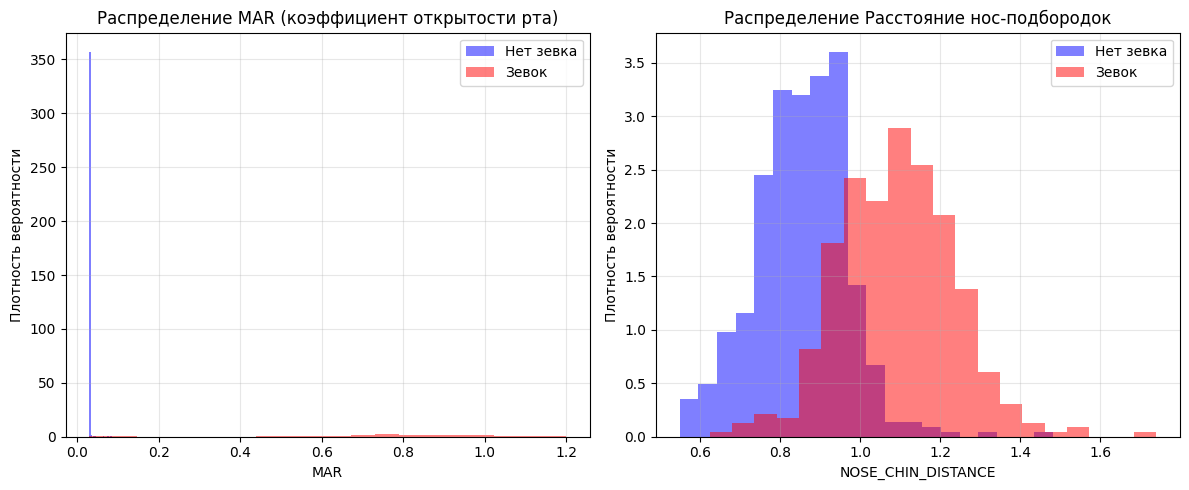

Графики распределений сохранены: scientific_results//plots/statistical_distributions.png
Визуализация метрик лица...


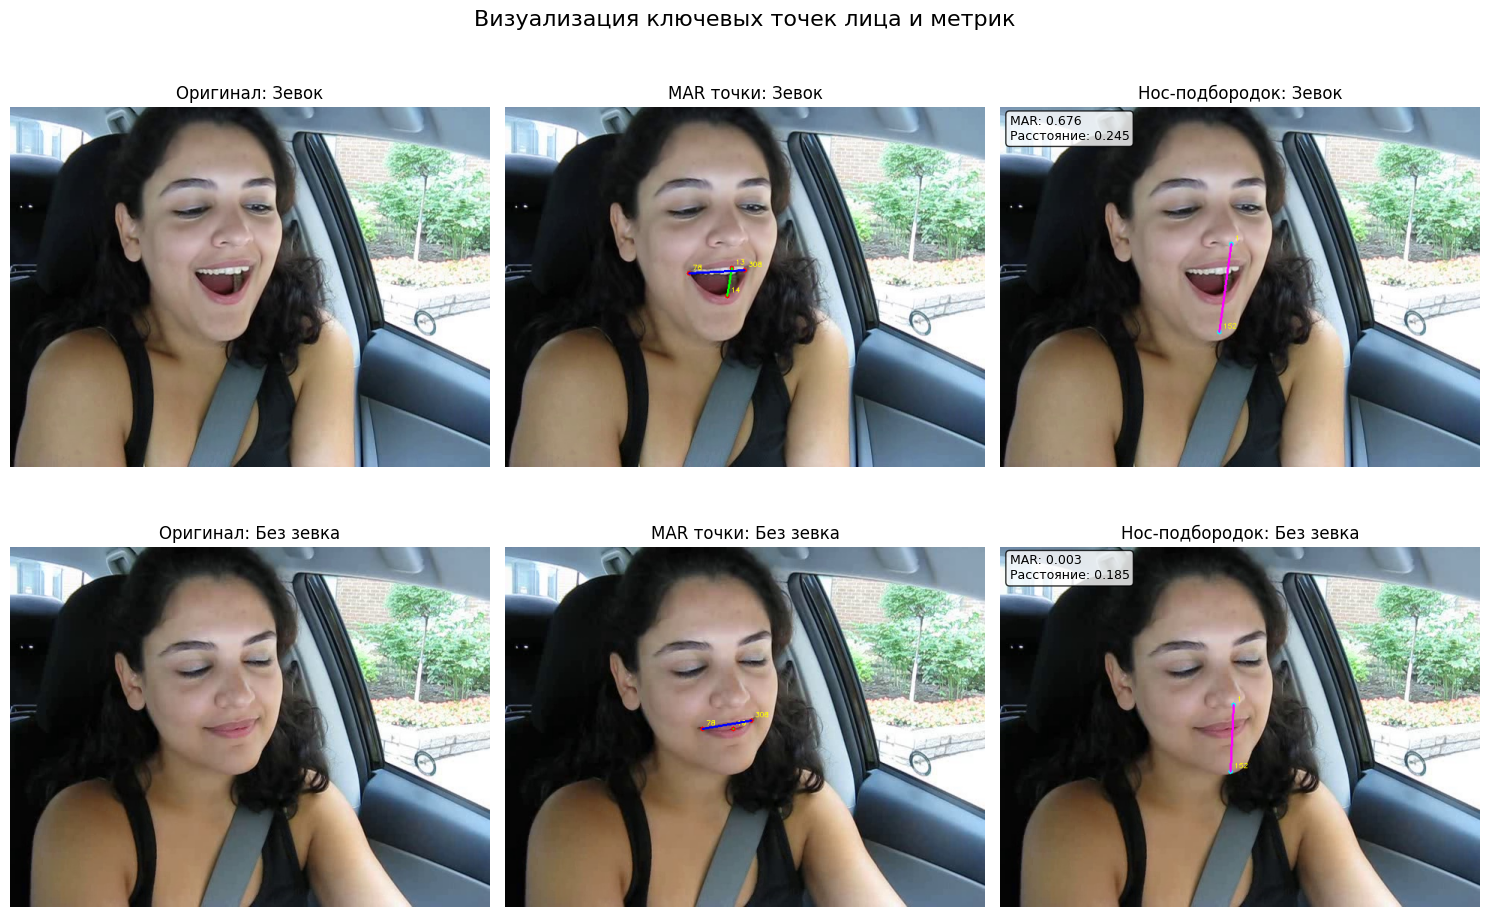

Визуализация сохранена: scientific_results//plots/facial_metrics_visualization.png

СТАТИСТИЧЕСКИЕ РЕЗУЛЬТАТЫ:
----------------------------------------
MAR: значимо (p=0.000000, d=-0.975)
NOSE_CHIN_DISTANCE: значимо (p=0.000000, d=-0.818)
ОТЧЕТ

1. СТАТИСТИЧЕСКИЙ АНАЛИЗ:
----------------------------------------
MAR: значимо (p=0.000000, d=-0.975)
NOSE_CHIN_DISTANCE: значимо (p=0.000000, d=-0.818)

2. РАСЧЕТ КОЭФФИЦИЕНТОВ K:
----------------------------------------
K_mar: K = 22.36
  Формула: Порог = mar_калибровки × 22.36
K_nose_chin_distance: K = 1.28
  Формула: Порог = nose_калибровки × 1.28

3. ПРАКТИЧЕСКИЕ РЕКОМЕНДАЦИИ:
----------------------------------------
Коэффициент для системы: K = 22.36
Формула обнаружения: MAR_текущий ≥ MAR_калибровки × 22.36

Примеры порогов для разных водителей:
  • MAR_водителя=0.020 → Порог = 0.447
  • MAR_водителя=0.025 → Порог = 0.559
  • MAR_водителя=0.030 → Порог = 0.671

Отчет сохранен: scientific_results//scientific_report.txt

ЧАСТЬ 2: ML АНАЛИЗ

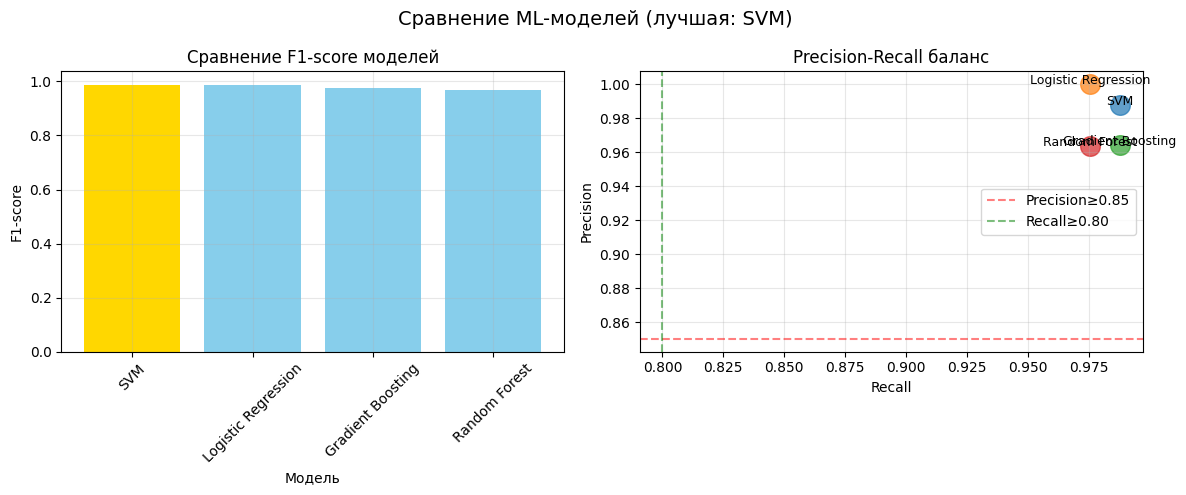

График сравнения сохранен: scientific_results//plots/model_comparison.png

 ОЦЕНКА ЛУЧШЕЙ МОДЕЛИ НА TEST ДАННЫХ
Лучшая модель: SVM
Размер тестовой выборки: 147 образцов

Результаты на тестовой выборке:
Accuracy: 0.986
Precision: 1.000
Recall: 0.972
F1-score: 0.986
ROC-AUC: 1.000

ПРОВЕРКА ТРЕБОВАНИЙ НА НЕВИДАННЫХ ДАННЫХ:
Precision ≥ 0.85: 1.000 ДА
Recall ≥ 0.80: 0.972 ДА
ТРЕБОВАНИЯ ВЫПОЛНЕНЫ НА ТЕСТОВЫХ ДАННЫХ!


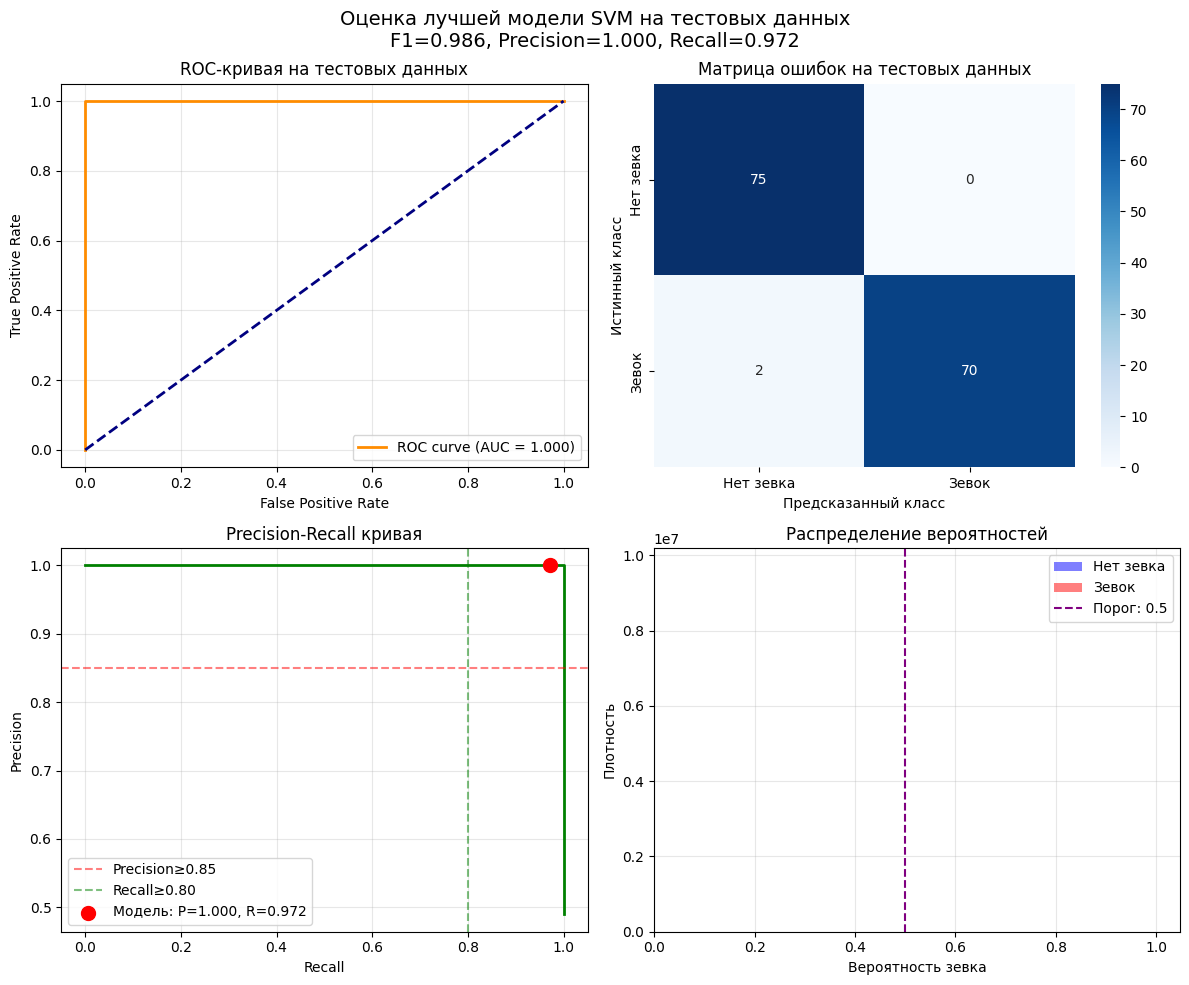

График оценки сохранен: scientific_results//plots/best_model_evaluation.png

Лучшая модель сохранена:
Модель: scientific_results//models/best_yawn_classifier.joblib
Скалер: scientific_results//models/feature_scaler.joblib
Метаданные: scientific_results//models/model_metadata.json

АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ

Тип анализа: Коэффициенты модели (абс. значения)
Модель: SVM
----------------------------------------
MAR: 100.0% (значение: 9.6912)
Расстояние нос-подбородок: 0.0% (значение: 0.0000)


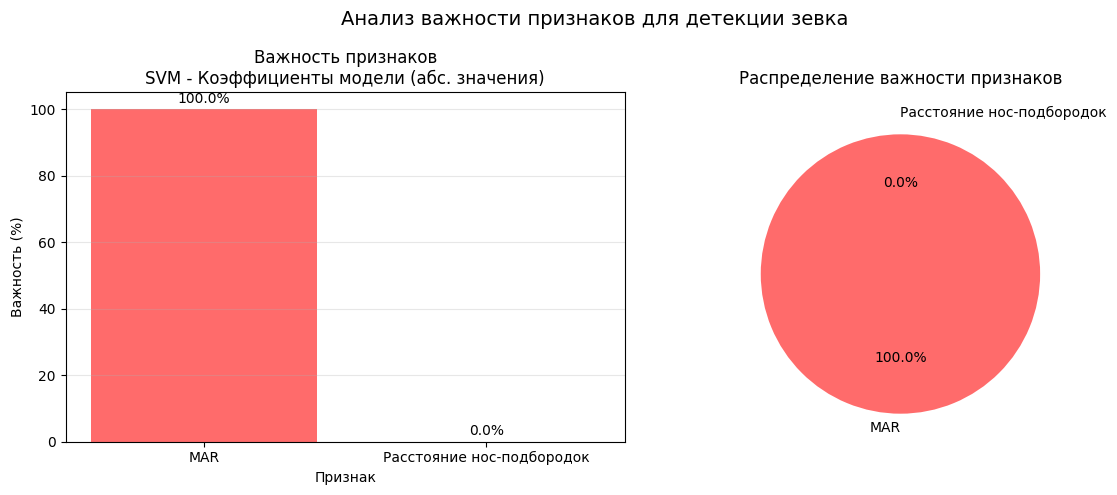


График важности признаков сохранен: scientific_results//plots/feature_importance.png

ИНТЕРПРЕТАЦИЯ РЕЗУЛЬТАТОВ
Основной признак: MAR (100.0%)
Второй по важности: Расстояние нос-подбородок (0.0%)
Соотношение: 6182967.2:1
ВЫВОД: MAR является доминирующим признаком

ПРОВЕРКА ГИПОТЕЗЫ:
1. MAR: 100.0%
2. Расстояние: 0.0%
✓ MAR является основным индикатором зевка (гипотеза подтверждается)

ЧАСТЬ 3: ФИНАЛЬНЫЙ ОТЧЕТ

ОТЧЕТ
ОТЧЕТ ПО СИСТЕМЕ МОНИТОРИНГА ЗЕВКОВ
Дата: 2026-02-07 19:13:32

1. КОЭФФИЦИЕНТЫ ДЛЯ MVP:
--------------------------------------------------
   K_mar: 22.36
     Формула: Порог_водителя = mar_калибровки × 22.36
   K_nose_chin_distance: 1.28
     Формула: Порог_водителя = nose_chin_distance_калибровки × 1.28

2. СТАТИСТИЧЕСКАЯ ЗНАЧИМОСТЬ ПРИЗНАКОВ:
--------------------------------------------------
   MAR: ЗНАЧИМО (p=0.000000, d=-0.975)
   NOSE_CHIN_DISTANCE: ЗНАЧИМО (p=0.000000, d=-0.818)

3. РЕЗУЛЬТАТЫ ML МОДЕЛЕЙ:
--------------------------------------------------
   Лучшая

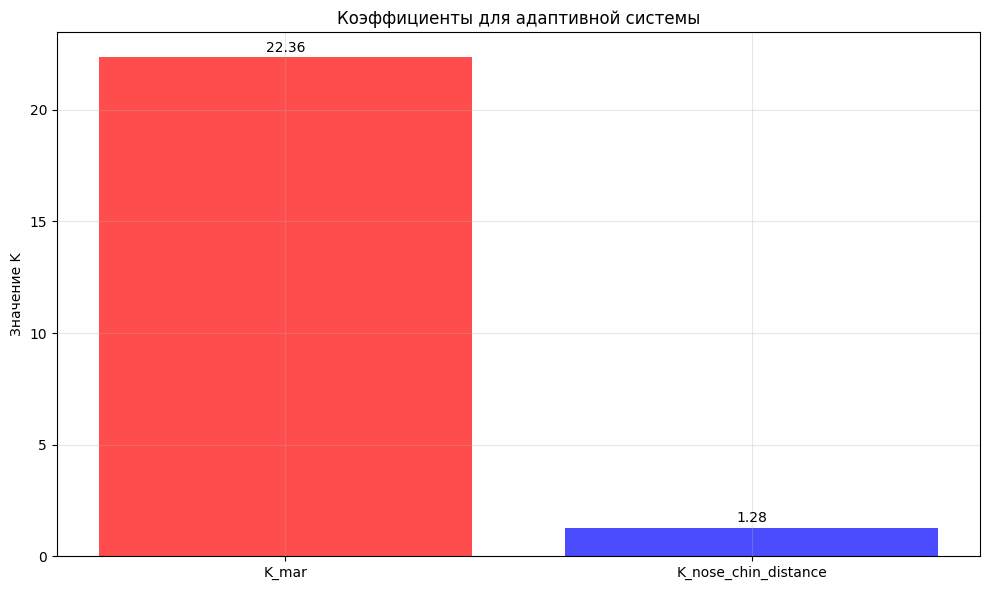


АДАПТИВНАЯ СИСТЕМА ОБНАРУЖЕНИЯ УСТАЛОСТИ:

        1. КОЭФФИЦИЕНТЫ:
        • K_MAR = 22.35943654121629 (для детекции зевка)
        • K_расстояние = 1.277224987024036 (для подтверждения зевка)
        • EAR_THRESHOLD_MULTIPLIER = 0.6 (для детекции закрытых глаз)

        2. ОБОСНОВАНИЕ КОЭФФИЦИЕНТА 0.6:
        • Физиологическое: Моргание = 40-50% закрытия глаза
        • Практическое: 60% от базового уровня дает:
            - Запас 10-15% для шума и индивидуальных различий
            - Надежное обнаружение при EAR < 50%
            - Минимизацию ложных срабатываний при EAR > 70%

        3. ФОРМУЛА АДАПТИВНОГО ПОРОГА:
        Порог_EAR = EAR_базовый_водителя × 0.6
            

Объяснение сохранено: scientific_results//adaptive_system_explanation.txt

Создание сравнительной визуализации...


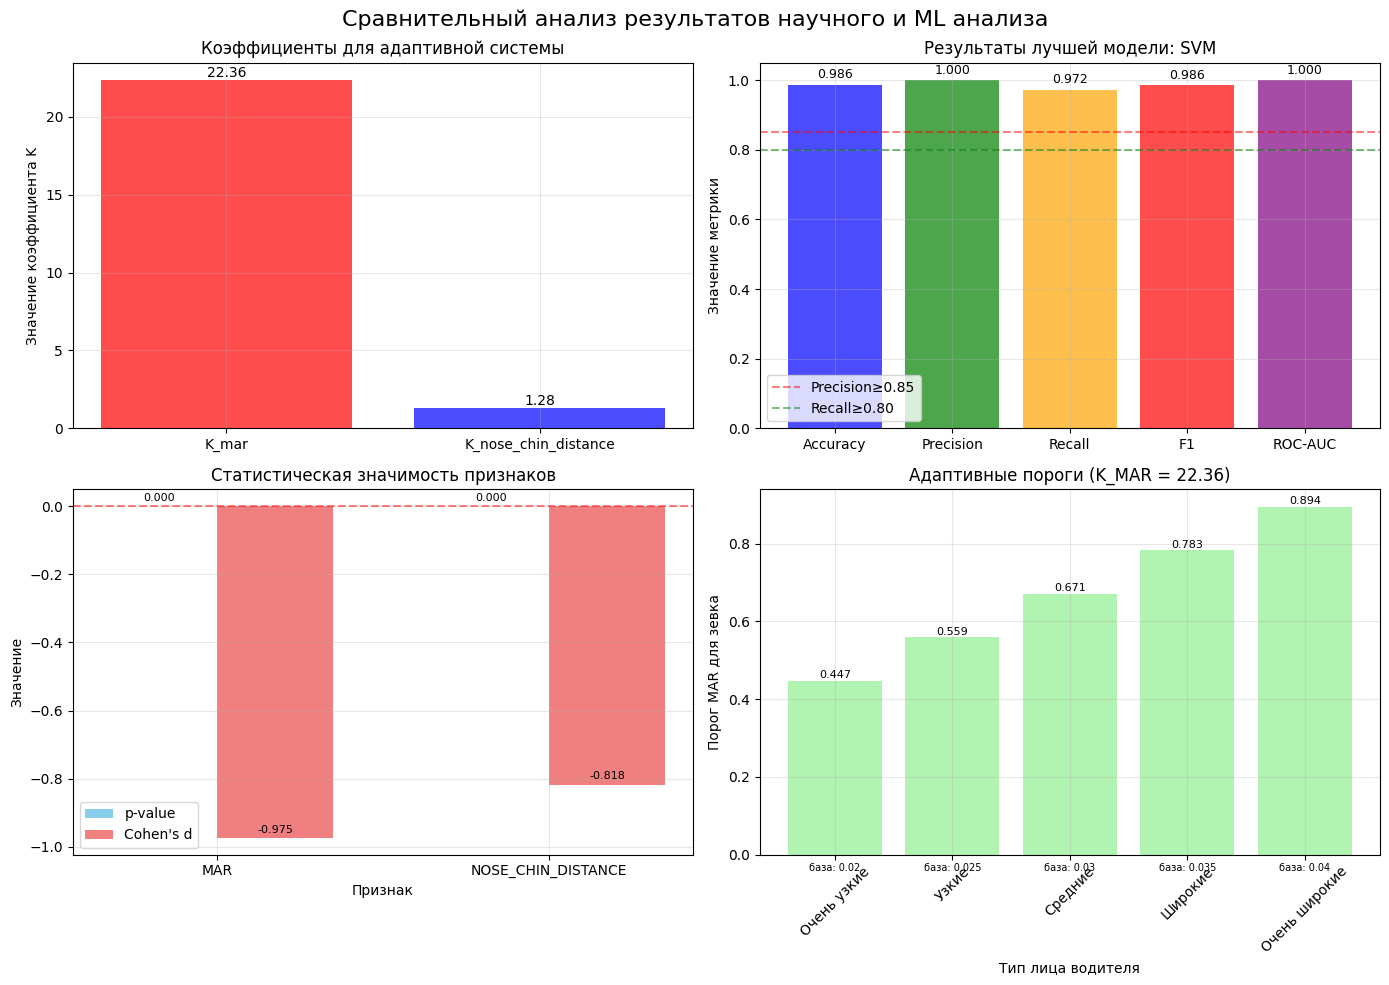

Сравнительная визуализация сохранена: scientific_results//plots/comparison_analysis.png

ЧАСТЬ 4: ТЕСТИРОВАНИЕ (опционально)
Загрузка модели...
✓ Модель загружена!
   Модель: SVM
   F1-score: 0.986

АНАЛИЗ РЕЗУЛЬТАТОВ ТЕСТА
Всего кадров: 293
Кадров с YAWN: 110
Процент YAWN: 37.5%

Статистика по классам:
  Детекций YAWN: 110 кадров
  Детекций NO YAWN: 183 кадров

Анализ детекций YAWN:
  Средний MAR: 0.172
  Среднее NC: 0.313
  Диапазон MAR: 0.075 - 0.560
  MAR 0.172 соответствует закрытому рту (< 0.3)
  Расстояние нос-подбородок 0.313 не соответствует зевку

Анализ детекций NO YAWN:
  Средний MAR: 0.053

Сравнение классов:
  Средний MAR при YAWN: 0.172
  Средний MAR при NO YAWN: 0.053
  Разница: 0.119

ДИАГНОСТИКА ПРОБЛЕМЫ МОДЕЛИ:
----------------------------------------
Распределение по уровню открытия рта:
  closed_mouth: 278 кадров (94.9%)
  smile_talk: 15 кадров (5.1%)
  yawn: 0 кадров (0.0%)

ОШИБКИ КЛАССИФИКАЦИИ:
  Ложные детекции зевка: 110 (100.0%)
  (MAR < 0.7, но классифициров

In [27]:
def main():
    """Главная функция запуска полного анализа"""
    
    print("="*70)
    print("АНАЛИЗ СИСТЕМЫ МОНИТОРИНГА ЗЕВКОВ")
    print("="*70)
    
    # Часть 1: Анализ (оригинальные данные)
    print("\n" + "="*60)
    print("ЧАСТЬ 1:")
    print("="*60)
    
    scientific_results = AnalysisPipeline.run_scientific_analysis_only()
    
    if not scientific_results:
        print("Ошибка в научном анализе")
        return
    
    # Часть 2: ML анализ (с аугментацией)
    print("\n" + "="*60)
    print("ЧАСТЬ 2: ML АНАЛИЗ")
    print("="*60)
    
    ml_results = AnalysisPipeline.run_ml_analysis()
    
    # Часть 3: Финальный отчет
    print("\n" + "="*60)
    print("ЧАСТЬ 3: ФИНАЛЬНЫЙ ОТЧЕТ")
    print("="*60)
    
    report_path = AnalysisPipeline.generate_final_report(scientific_results, ml_results)
    
    # Часть 4: Тестирование на камере (опционально)
    print("\n" + "="*60)
    print("ЧАСТЬ 4: ТЕСТИРОВАНИЕ (опционально)")
    print("="*60)
    
    response = input("Запустить тестирование на камере? (да/нет): ").strip().lower()
    if response == 'да':
        tester = CameraModelTest()
        if tester.model:
            seconds = input("Длительность теста (секунд, по умолчанию 30): ").strip()
            seconds = int(seconds) if seconds.isdigit() else 30
            tester.run_test(seconds=seconds)
    
    print("\n" + "="*70)
    print("АНАЛИЗ ЗАВЕРШЕН")
    print(f"Отчет сохранен: {report_path}")
    print("="*70)


# Запуск
if __name__ == "__main__":
    main()

Приёмочные тесты

6.1. Тест на корректность расчёта коэффициентов

In [12]:
def test_6_1_coefficient_calculation_run():
    
    print("\nТЕСТ 6.1: Проверка расчета коэффициентов")
    print("="*60)
    
    synthetic_data = pd.DataFrame({
        'mar': [0.04, 0.05, 0.06, 0.07, 0.6, 0.7, 0.8, 0.9],
        'nose_chin_distance': [1.0, 1.1, 1.2, 1.3, 1.5, 1.6, 1.7, 1.8],
        'label': [0, 0, 0, 0, 1, 1, 1, 1]
    })
    
    # Ручной расчет для проверки
    yawn_mar = synthetic_data[synthetic_data['label'] == 1]['mar']
    no_yawn_mar = synthetic_data[synthetic_data['label'] == 0]['mar']
    expected_K_mar = np.percentile(yawn_mar, 25) / np.median(no_yawn_mar)
    
    yawn_nose = synthetic_data[synthetic_data['label'] == 1]['nose_chin_distance']
    no_yawn_nose = synthetic_data[synthetic_data['label'] == 0]['nose_chin_distance']
    expected_K_nose = np.median(yawn_nose) / np.median(no_yawn_nose)
    
    # Запускаем анализ, но перехватываем вывод
    analyzer = ScientificAnalyzer(synthetic_data, "тестовые данные")
    analyzer.perform_statistical_analysis()
    
    # Вручную вызываем расчет коэффициентов без сохранения
    coefficients = {}
    
    for feature in ['mar', 'nose_chin_distance']:
        if feature in analyzer.statistical_results:
            yawn_values = synthetic_data[synthetic_data['label'] == 1][feature]
            no_yawn_values = synthetic_data[synthetic_data['label'] == 0][feature]
            
            if len(yawn_values) > 0 and len(no_yawn_values) > 0:
                if feature == 'mar':
                    yawn_value = yawn_values.quantile(0.25)
                    no_yawn_median = max(no_yawn_values.median(), 0.03)
                else:
                    yawn_value = yawn_values.median()
                    no_yawn_median = max(no_yawn_values.median(), 0.8)
                
                K = yawn_value / no_yawn_median if no_yawn_median > 0 else 1.0
                coefficients[f'K_{feature}'] = K
    
    calculated_K_mar = coefficients.get('K_mar', 0)
    calculated_K_nose = coefficients.get('K_nose_chin_distance', 0)
    
    diff_mar = abs(calculated_K_mar - expected_K_mar)
    diff_nose = abs(calculated_K_nose - expected_K_nose)
    
    print(f"Ожидаемые: K_MAR={expected_K_mar:.4f}, K_nose={expected_K_nose:.4f}")
    print(f"Рассчитанные: K_MAR={calculated_K_mar:.4f}, K_nose={calculated_K_nose:.4f}")
    print(f"Разницы: MAR={diff_mar:.6f}, нос={diff_nose:.6f}")
    
    success = (diff_mar <= 0.01) and (diff_nose <= 0.01)
    
    if success:
        print("ТЕСТ ПРОЙДЕН: расхождение <= 0.01")
    else:
        print("ТЕСТ НЕ ПРОЙДЕН")
    
    return success
test_6_1_coefficient_calculation_run()


ТЕСТ 6.1: Проверка расчета коэффициентов
Размер выборки: 8 образцов
Зевок: 4 образцов
Нет зевка: 4 образцов

--- Анализ признака: MAR ---
Зевок: среднее=0.750, ст.откл.=0.129
Нет зевка: среднее=0.055, ст.откл.=0.013
U-тест: U=16, p=0.028571
Размер эффекта Cohen's d: -1.000

--- Анализ признака: NOSE_CHIN_DISTANCE ---
Зевок: среднее=1.650, ст.откл.=0.129
Нет зевка: среднее=1.150, ст.откл.=0.129
U-тест: U=16, p=0.028571
Размер эффекта Cohen's d: -1.000
Ожидаемые: K_MAR=12.2727, K_nose=1.4348
Рассчитанные: K_MAR=12.2727, K_nose=1.4348
Разницы: MAR=0.000000, нос=0.000000
ТЕСТ ПРОЙДЕН: расхождение <= 0.01


np.True_

6.2. Тест на статистическую значимость

In [13]:
def test_6_2_statistical_significance():
    """
    Приёмочный тест 6.2: Статистическая значимость
    Критерий: p-value < 0.001 для обоих признаков
    """
    print("\n" + "="*60)
    print("ПРИЁМОЧНЫЙ ТЕСТ 6.2: Статистическая значимость")
    print("="*60)
    
    # Используем РЕАЛЬНЫЕ данные из анализа
    
    
    try:
        with open("scientific_results/scientific_coefficients.json", 'r') as f:
            results = json.load(f)
        
        p_value_mar = results['statistical_results']['mar']['p_value']
        p_value_nose = results['statistical_results']['nose_chin_distance']['p_value']
        
        print(f"p-value для MAR: {p_value_mar:.6f}")
        print(f"p-value для расстояния нос-подбородок: {p_value_nose:.6f}")
        
        # Критерий успеха из ТЗ
        success = (p_value_mar < 0.001) and (p_value_nose < 0.001)
        
        if success:
            print("\n ТЕСТ 6.2 ПРОЙДЕН: p-value < 0.001 для обоих признаков")
        else:
            print("\n ТЕСТ 6.2 НЕ ПРОЙДЕН:")
            if p_value_mar >= 0.001:
                print(f"   p-value MAR ({p_value_mar:.6f}) ≥ 0.001")
            if p_value_nose >= 0.001:
                print(f"   p-value расстояния ({p_value_nose:.6f}) ≥ 0.001")
        
        return success
        
    except FileNotFoundError:
        print(" Файл с результатами не найден!")
        print("   Запустите сначала полный анализ (main())")
        return False
test_6_2_statistical_significance()


ПРИЁМОЧНЫЙ ТЕСТ 6.2: Статистическая значимость
p-value для MAR: 0.000000
p-value для расстояния нос-подбородок: 0.000000

 ТЕСТ 6.2 ПРОЙДЕН: p-value < 0.001 для обоих признаков


True

6.3. Тест на соответствие эталонным ML-метрикам

In [14]:
def test_6_3_ml_metrics():
    """
    Приёмочный тест 6.3: Соответствие ML-метрикам
    Критерий: F1-score ≥ 0.98 на тестовой выборке
    """
    print("\n" + "="*60)
    print("ПРИЁМОЧНЫЙ ТЕСТ 6.3: ML-метрики")
    print("="*60)
    
    try:
        with open("scientific_results/models/model_metadata.json", 'r') as f:
            metadata = json.load(f)
        
        test_metrics = metadata['test_metrics']
        
        f1_score = test_metrics['f1']
        precision = test_metrics['precision']
        recall = test_metrics['recall']
        
        print(f"Лучшая модель: {metadata['model_name']}")
        print(f"F1-score: {f1_score:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        
        # Критерий успеха из ТЗ
        success = f1_score >= 0.98
        
        if success:
            print("\n ТЕСТ 6.3 ПРОЙДЕН: F1-score ≥ 0.98")
        else:
            print(f"\n ТЕСТ 6.3 НЕ ПРОЙДЕН: F1-score ({f1_score:.4f}) < 0.98")
        
        # Дополнительная проверка (не в ТЗ, но хорошая практика)
        if precision >= 0.85 and recall >= 0.80:
            print("   Дополнительно: Precision ≥ 0.85 и Recall ≥ 0.80 ✓")
        else:
            print("     Precision или Recall ниже желаемых значений")
        
        return success
        
    except FileNotFoundError:
        print(" Файл метаданных модели не найден!")
        print("   Запустите сначала ML анализ")
        return False
test_6_3_ml_metrics()


ПРИЁМОЧНЫЙ ТЕСТ 6.3: ML-метрики
Лучшая модель: SVM
F1-score: 0.9930
Precision: 1.0000
Recall: 0.9861

 ТЕСТ 6.3 ПРОЙДЕН: F1-score ≥ 0.98
   Дополнительно: Precision ≥ 0.85 и Recall ≥ 0.80 ✓


True

In [15]:
import unittest
import numpy as np
import pandas as pd
import json

class TestFormulas(unittest.TestCase):
    """Тесты математических формул"""
    
    def test_mar_formula(self):
        """Тест формулы MAR"""
        top = (0.5, 0.3)
        bottom = (0.5, 0.7)
        left = (0.3, 0.5)
        right = (0.7, 0.5)
        
        h, w = 100, 100
        
        top_px = (top[0] * w, top[1] * h)
        bottom_px = (bottom[0] * w, bottom[1] * h)
        left_px = (left[0] * w, left[1] * h)
        right_px = (right[0] * w, right[1] * h)
        
        vertical = np.sqrt((top_px[0] - bottom_px[0])**2 + (top_px[1] - bottom_px[1])**2)
        horizontal = np.sqrt((left_px[0] - right_px[0])**2 + (left_px[1] - right_px[1])**2)
        
        mar = vertical / horizontal if horizontal > 0 else 0
        
        self.assertAlmostEqual(vertical, 40.0, delta=0.1)
        self.assertAlmostEqual(horizontal, 40.0, delta=0.1)
        self.assertAlmostEqual(mar, 1.0, delta=0.01)
    
    def test_nose_chin_distance_formula(self):
        """Тест формулы расстояния нос-подбородок"""
        nose = (0.5, 0.4)
        chin = (0.5, 0.8)
        left_eye = (0.3, 0.35)
        right_eye = (0.7, 0.35)
        
        h, w = 100, 100
        
        nose_px = np.array([nose[0] * w, nose[1] * h])
        chin_px = np.array([chin[0] * w, chin[1] * h])
        absolute = np.linalg.norm(nose_px - chin_px)
        
        face_width = abs(left_eye[0] - right_eye[0]) * w
        normalized = absolute / face_width if face_width > 0 else 0
        
        self.assertAlmostEqual(absolute, 40.0, delta=0.1)
        self.assertAlmostEqual(face_width, 40.0, delta=0.1)
        self.assertAlmostEqual(normalized, 1.0, delta=0.01)
    
    def test_coefficient_k_calculation(self):
        """Тест расчета коэффициента K"""
        yawn_values = [0.5, 0.6, 0.7, 0.8, 0.9]
        no_yawn_values = [0.01, 0.02, 0.03, 0.04, 0.05]
        
        yawn_25 = np.percentile(yawn_values, 25)
        yawn_median = np.median(yawn_values)
        no_yawn_median = np.median(no_yawn_values)
        
        K_mar = yawn_25 / no_yawn_median if no_yawn_median > 0 else 1.0
        K_nose = yawn_median / no_yawn_median if no_yawn_median > 0 else 1.0
        
        self.assertGreater(K_mar, 1)
        self.assertGreater(K_nose, 1)
        self.assertGreater(K_mar, 10)
    
    def test_threshold_calculation(self):
        """Тест расчета порога обнаружения"""
        calibration_mar = 0.025
        calibration_nose = 0.9
        K_mar = 8.21
        K_nose = 1.19
        
        threshold_mar = calibration_mar * K_mar
        threshold_nose = calibration_nose * K_nose
        
        self.assertGreater(threshold_mar, calibration_mar)
        self.assertGreater(threshold_nose, calibration_nose)
        self.assertAlmostEqual(threshold_mar, 0.205, delta=0.01)
        self.assertAlmostEqual(threshold_nose, 1.071, delta=0.01)
    
    def test_detection_logic(self):
        """Тест логики обнаружения"""
        MAR_THRESHOLD = 0.205
        NOSE_THRESHOLD = 1.071
        
        test_cases = [
            (0.15, 0.95, "Норма"),
            (0.70, 0.95, "Возможно"),
            (0.70, 1.10, "Зевок"),
        ]
        
        for mar, nose, expected in test_cases:
            if mar >= MAR_THRESHOLD and nose >= NOSE_THRESHOLD:
                result = "Зевок"
            elif mar >= MAR_THRESHOLD or nose >= NOSE_THRESHOLD:
                result = "Возможно"
            else:
                result = "Норма"
            
            self.assertEqual(result, expected)


class TestDataOperations(unittest.TestCase):
    """Тесты операций с данными"""
    
    def test_dataframe_creation(self):
        """Тест создания DataFrame"""
        data = {
            'mar': [0.01, 0.02, 0.03, 0.70, 0.71, 0.72],
            'nose_chin_distance': [0.9, 0.91, 0.92, 1.05, 1.06, 1.07],
            'label': [0, 0, 0, 1, 1, 1]
        }
        
        df = pd.DataFrame(data)
        
        self.assertEqual(len(df), 6)
        self.assertEqual(df['label'].sum(), 3)
        
        yawn_df = df[df['label'] == 1]
        no_yawn_df = df[df['label'] == 0]
        
        self.assertEqual(len(yawn_df), 3)
        self.assertEqual(len(no_yawn_df), 3)
    
    def test_statistical_analysis(self):
        """Тест статистического анализа"""
        data = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        
        mean = np.mean(data)
        median = np.median(data)
        std = np.std(data)
        p25 = np.percentile(data, 25)
        p75 = np.percentile(data, 75)
        
        self.assertAlmostEqual(mean, 0.55, delta=0.01)
        self.assertAlmostEqual(median, 0.55, delta=0.01)
        self.assertAlmostEqual(std, 0.287, delta=0.01)
        self.assertAlmostEqual(p25, 0.325, delta=0.01)
        self.assertAlmostEqual(p75, 0.775, delta=0.01)
    
    def test_json_serialization(self):
        """Тест сериализации JSON"""
        test_data = {
            "coefficients": {
                "K_mar": {"value": 8.21},
                "K_nose": {"value": 1.19}
            },
            "statistics": {
                "mar": {"p_value": 0.000001, "significant": True}
            }
        }
        
        json_str = json.dumps(test_data)
        parsed_data = json.loads(json_str)
        
        self.assertIn("coefficients", parsed_data)
        self.assertIn("K_mar", parsed_data["coefficients"])
        self.assertAlmostEqual(parsed_data["coefficients"]["K_mar"]["value"], 8.21, delta=0.01)
        self.assertTrue(parsed_data["statistics"]["mar"]["significant"])
    
    def test_data_filtering(self):
        """Тест фильтрации данных"""
        data = {
            'mar': [0.001, 0.02, 0.03, 0.70, 2.5, 0.72],
            'label': [0, 0, 0, 1, 1, 1]
        }
        
        df = pd.DataFrame(data)
        filtered_df = df[(df['mar'] >= 0.01) & (df['mar'] <= 1.0)]
        
        self.assertEqual(len(filtered_df), 4)
        self.assertTrue((filtered_df['mar'] >= 0.01).all())
        self.assertTrue((filtered_df['mar'] <= 1.0).all())
    
    def test_class_separation(self):
        """Тест разделения по классам"""
        data = {
            'mar': [0.01, 0.02, 0.03, 0.70, 0.71, 0.72],
            'nose_chin_distance': [0.9, 0.91, 0.92, 1.05, 1.06, 1.07],
            'label': [0, 0, 0, 1, 1, 1]
        }
        
        df = pd.DataFrame(data)
        yawn_df = df[df['label'] == 1]
        no_yawn_df = df[df['label'] == 0]
        
        mar_yawn_mean = yawn_df['mar'].mean()
        mar_no_yawn_mean = no_yawn_df['mar'].mean()
        
        self.assertGreater(mar_yawn_mean, mar_no_yawn_mean * 10)
        self.assertGreater(yawn_df['nose_chin_distance'].mean(), 
                          no_yawn_df['nose_chin_distance'].mean())


def run_all_tests():
    """Запуск всех тестов"""
    print("Запуск всех тестов")
    print("=" * 50)
    
    test_suite = unittest.TestSuite()
    test_suite.addTest(unittest.TestLoader().loadTestsFromTestCase(TestFormulas))
    test_suite.addTest(unittest.TestLoader().loadTestsFromTestCase(TestDataOperations))
    
    runner = unittest.TextTestRunner(verbosity=2)
    result = runner.run(test_suite)
    
    print("\nИтоговые результаты:")
    print(f"Пройдено: {result.testsRun - len(result.failures) - len(result.errors)}")
    print(f"Всего: {result.testsRun}")
    
    if result.failures:
        print("Есть непройденные тесты")
    else:
        print("Все тесты пройдены успешно")


if __name__ == "__main__":
    run_all_tests()

test_coefficient_k_calculation (__main__.TestFormulas.test_coefficient_k_calculation)
Тест расчета коэффициента K ... ok
test_detection_logic (__main__.TestFormulas.test_detection_logic)
Тест логики обнаружения ... ok
test_mar_formula (__main__.TestFormulas.test_mar_formula)
Тест формулы MAR ... ok
test_nose_chin_distance_formula (__main__.TestFormulas.test_nose_chin_distance_formula)
Тест формулы расстояния нос-подбородок ... ok
test_threshold_calculation (__main__.TestFormulas.test_threshold_calculation)
Тест расчета порога обнаружения ... ok
test_class_separation (__main__.TestDataOperations.test_class_separation)
Тест разделения по классам ... ok
test_data_filtering (__main__.TestDataOperations.test_data_filtering)
Тест фильтрации данных ... ok
test_dataframe_creation (__main__.TestDataOperations.test_dataframe_creation)
Тест создания DataFrame ... ok
test_json_serialization (__main__.TestDataOperations.test_json_serialization)
Тест сериализации JSON ... ok
test_statistical_analysi

Запуск всех тестов

Итоговые результаты:
Пройдено: 10
Всего: 10
Все тесты пройдены успешно
